# Olas epidémicas

Vamos a analizar diferentes escenarios, de olas epidémicas.


<div class="alert alert-block alert-info">
Cada hipotesis tiene distintos escenarios. Y cada escenario un juego de parámetros diferentes.
</div>
En cada hipotesis, intentaremos encontrar aquellos umbrales de confinamiento/desconfinamiento que minimicen los valores de olas, días de confinamiento, e infectados totales, por cada escenario de cada hipotesis

Tabla de contenidos: 

- Cálculo de capacidad del sistema sanitario

- Cálculos de prevalencias

- Cálculos de infectados, sin umbrales de confinamiento


 Hipótesis a estudiar :

- Impacto de usar mascarillas.

- Airborne. ¿ Es aerotransportado el virus ? 

- ¿ Habrá una segunda ola en vacations ?

- Datos de Madrid.

- Casos importados - ¿ Puede haber apertura de aeropuertos ?

- Datos agregados 

- Conclusiones

## Parametros de la simulación


| Parámetro | Significado 	  	
|---	|---		
| INITIAL_DATE 	| Fecha de inicio de la simulación
| FINAL_DATE 	| Fecha de fin de la simulación.
| INITIAL_RECOVERED_PEOPLE 	| Nº de personas con anticuerpos al comienzo de la simulación.
| INITIAL_INFECTED_PEOPLE 	|  Nº de personas infectadas al comienzo la simulación.
| R0_max 	| R0 de la simulación cuando no hay confinamiento.
| R0_min 	| R0 de la simulación cuando si hay confinamiento.
| R0_summer 	| R0 de la simulación durante el periodo estival
| max_lockdown_thresold 	| Umbral máximo de personas infectadas a la vez, que si se sobrepasa se inicia el confinamiento.
| min_unlockdown_thresold 	| Umbral mínimo de personas infectadas a la vez, que si se sobrepasa se finaliza el confinamiento.
| outbreaks_detection_thresold 	| Umbral de personas infectadas a la vez, a la que podemos hacer el seguimiento de contactos.
| outbreaks_detection_efectivity_porcentage 	| Porcentaje de contactos infectados de un infectado al que se la hace el seguimiento, que el sistema de detección de brotes puede detectar.
| imported_cases_lockdown_weekly 	| Casos importados del extranjero a la semana, cuando si hay confinamiento.
| imported_cases_unlockdown_weekly 	| Casos importados del extranjero a la semana, cuando no hay confinamiento.
 		


Otros parámetros no configurables
 - Fecha Inicio y Fecha de Fin periodo estival.
 - Población total del pais.
 - Capacidad hospitalaria del pais en camas UCI
 - Tiempo en días que tarda un infectado en infectar a otros.



In [1]:
import numpy as np
import pandas as pd 
import time
from datetime import datetime, date, time, timedelta
from IPython.display import display, HTML
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV,ParameterGrid
from IPython.display import display, HTML
import janitor
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',100)

INITIAL_RECOVERED_PEOPLE = 1
prevalencia = 0 
R0 = 5.7
DIAS_EN_REINFECTAR=5


## Cálculo de capacidad del sistema sanitario

In [2]:
### Calculamos la capacidad del sistema sanitario.
####Cuanto se tardaria en copar las camas de uci en cada escenario
"""
"Antes de la crisis sanitaria, España disponía de unas 4.500 camas UCI, capacidad que aumentó hasta las 8.000"
Madrid cuenta con 1.750 camas
Cataluña tiene 1.722 camas
Andalucía con 1.200 camas.
Canarias cuenta con 595 camas.
Euskadi con capacidad para 550 camas. 
Castilla-León tiene 500 camas.
Aragón con 300 camas.
Castilla-La Mancha cuenta con 300 camas.
Galicia tiene 274 camas.
Comunidad Valenciana con 254 plazas libres.
Navarra con 156 camas. 
Murcia tiene 123 camas. 
Baleares con 120 camas.
Extremadura cuenta con 100 camas.
Cantabria con 64 camas.
Asturias cuenta con 61 camas. 
La Rioja tiene 23 plazas. 
TOTAL = 8092
"""

"De los 11.424 pacientes de Covid-19 ingresados en Madrid, según datos del Ministerio de Sanidad, 1.332 están en la UCI, un 11,7%."
"Si para una prevalencia de 10% (750000 personas para la comunidad de madrid)"

# Calculamos la capacidad del sistema sanitario - el nº de enfermos que puede haber antes de que colapse
UCI_BEDS=8092 

NEED_UCI_PERCENTAGE
NEED_HOSPITAL_PERCENTAGE = 0.088 # https://www.redaccionmedica.com/secciones/sanidad-hoy/coronavirus-en-personal-sanitario-hospitalizacion-en-el-8-8-de-casos-9925
NEED_UCI_PERCENTAGE = 0.05  #https://www.elperiodico.com/es/sociedad/20200316/coronavirus-hospitalizados-graves-contagio-7891866

HEALT_SYSTEM_CAPACITY = UCI_BEDS / NEED_HOSPITAL_PERCENTAGE / NEED_UCI_PERCENTAGE
HEALT_SYSTEM_CAPACITY = int(HEALT_SYSTEM_CAPACITY)

print ("La estimacion de la capacidad del sistema sanitario es " , HEALT_SYSTEM_CAPACITY ) 


La estimacion de la capacidad del sistema sanitario es  1839090


In [3]:
def Get_Header(GENERACIONES,df,INITIAL_DATE = '2020-02-01'):
    array_fechas = []
    FECHA_INICIAL = datetime.strptime(INITIAL_DATE, "%Y-%m-%d")
    modified_date = FECHA_INICIAL
    NUM_GENERACIONES = range(1,GENERACIONES)
    for generacion in NUM_GENERACIONES:
        modified_date += timedelta(days=DIAS_EN_REINFECTAR)
        array_fechas.append(datetime.strftime(modified_date, "%Y-%m-%d"))
    df.columns = array_fechas
    return df

def Calcular_Cuadro_Prevalencias( R0,
                                 GENERACIONES,
                                 ARRAY_PREVALENCIAS, 
                                 INITIAL_RECOVERED_PEOPLE=1,
                                 INITIAL_DATE = '2020-02-01',
                                 outbreaks_detection_thresold = 0  , 
                                 outbreaks_detection_efectivity_porcentage = 0, 
                                 INCREMENTO_SEMANAL = 0 ,
                                 DEBUG=False):
    if DEBUG : 
        print (f""" Calcular_Cuadro_Prevalencias infectados_en_esta_generacion {R0},{GENERACIONES},{ARRAY_PREVALENCIAS}, {INITIAL_RECOVERED_PEOPLE}, {INITIAL_DATE} ,{INCREMENTO_SEMANAL}""")
    diccionario_prevalencias = {}
    array=[]

    for prevalencia in ARRAY_PREVALENCIAS : 
        infectados_en_esta_generacion = INITIAL_RECOVERED_PEOPLE
        NUM_GENERACIONES = range(1,GENERACIONES)
        array=[]
        for generacion in NUM_GENERACIONES:
            prevalencia_esta_iteracion =  min(45000000,np.sum(array)) / 45000000
            if DEBUG : print ("infectados_en_esta_generacion",infectados_en_esta_generacion,R0,prevalencia,prevalencia_esta_iteracion)
            # Si estamos por debajo del umbral de deteccion de brotes, aplicamos el outbreaks_detection_efectivity_porcentage, 
            # que disminuye efectivamente el R0
            R0_esta_iteracion = R0 * ( 1 - outbreaks_detection_efectivity_porcentage) if infectados_en_esta_generacion < outbreaks_detection_thresold else R0
            infectados_en_esta_generacion = int(infectados_en_esta_generacion * R0_esta_iteracion * max(0,( 1 - (prevalencia + prevalencia_esta_iteracion)) ) )
            # Incrementos importados
            infectados_en_esta_generacion += int (INCREMENTO_SEMANAL * DIAS_EN_REINFECTAR / 7 )
            # A esta cantidad sumamos el incremento en esta generacion
            array.append(infectados_en_esta_generacion)
        diccionario_prevalencias['prevalencia ' + str("{:.1f}".format(prevalencia)) + ' y R0 ' + str(R0)] = array
    df = pd.DataFrame.from_dict(diccionario_prevalencias,'index')    
    df = Get_Header(GENERACIONES,df,INITIAL_DATE)
    df = df.astype(np.int64)
    return df.T

# Auxiliary functions
def interpolate_dataframe(df,freq):
    if freq == 'H':
        rng = pd.date_range(df.index.min(), df.index.max() + pd.Timedelta(23, 'H'), freq='H')
    elif freq == 'D' :  
        rng = pd.date_range(
            datetime.strptime(str(df.index.min())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S") ,
            datetime.strptime(str(df.index.max())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S"), 
            freq='D')
        df.index = pd.to_datetime(df.index)  
    df2 = df.reindex(rng)
    df = df2
    for column in df.columns :
        s = pd.Series(df[column])
        s.interpolate(method="quadratic", inplace =True)
        df[column] = pd.DataFrame([s]).T
    df.index.name = 'Fecha'
    return df


# first execution
GENERACIONES=8
ARRAY_PREVALENCIAS = np.linspace(0,0.70,8)
ARRAY_PREVALENCIAS

from matplotlib import pyplot as plt    
import pandas as pd
import numpy as np

def Get_Chart(df, title="default", xlabel="" ):
    fig = plt.figure(figsize=(8, 6), dpi=80)

    for ca in df.columns:
        plt.plot(df[ca])
        plt.legend(df.columns)
        fig.suptitle(title, fontsize=20)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=45)
    plt.gca().set_xlabel(xlabel)
    return plt

def debug_Calcular_Cuadro_Prevalencias():
# DEBUG
    INITIAL_RECOVERED_PEOPLE  = 1000
    R0_min             = 1.702 
    GENERACIONES_BAJADA= 30 
    ARRAY_PREVALENCIAS = [0.1]  
    INITIAL_DATE  = '2020-07-01'
    INCREMENTO_SEMANAL = 50

    df_temp =  Calcular_Cuadro_Prevalencias( 
        R0                 = R0_min,
        GENERACIONES       = GENERACIONES_BAJADA,
        ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS,
        INITIAL_RECOVERED_PEOPLE  = INITIAL_RECOVERED_PEOPLE,
        INITIAL_DATE  = INITIAL_DATE    ,
        DEBUG              = False, 
        INCREMENTO_SEMANAL = INCREMENTO_SEMANAL
    )
    return df_temp

##debug_Calcular_Cuadro_Prevalencias()
    

In [4]:
#### PRedicciones a futuro

"""
Crear 30.
Borrar las mayores de umbral superios.
Aplicar hasta que haya menos de x
"""
from datetime import date
GENERACIONES=15

def calcular_prevision(**kwargs) :
    """Calcula la prevision en ciclos de subida y bajada"""
    """FINAL_DATE,
    INITIAL_DATE,
    INITIAL_RECOVERED_PEOPLE,
    INITIAL_INFECTED_PEOPLE,
    R0_max,
    R0_min,
    max_lockdown_thresold,
    min_unlockdown_thresold):
"""
    FINAL_DATE                   = kwargs.pop('FINAL_DATE')
    INITIAL_DATE                 = kwargs.pop('INITIAL_DATE')
    INITIAL_RECOVERED_PEOPLE                 = kwargs.pop('INITIAL_RECOVERED_PEOPLE')
    INITIAL_INFECTED_PEOPLE       = kwargs.pop('INITIAL_INFECTED_PEOPLE')
    R0_max                            = kwargs.pop('R0_max')
    R0_min                            = kwargs.pop('R0_min')
    RO_calor                          = kwargs.pop('RO_calor',1.702 )
    max_lockdown_thresold                        = kwargs.pop('max_lockdown_thresold')
    min_unlockdown_thresold                        = kwargs.pop('min_unlockdown_thresold')
    GENERACIONES_SUBIDA               = kwargs.pop('GENERACIONES_SUBIDA',16)
    GENERACIONES_BAJADA               = kwargs.pop('GENERACIONES_BAJADA',22)
    outbreaks_detection_thresold           = kwargs.pop('outbreaks_detection_thresold',7200)
    outbreaks_detection_efectivity_porcentage       = kwargs.pop('outbreaks_detection_efectivity_porcentage',.25)
    imported_cases_lockdown_weekly    = kwargs.pop('imported_cases_lockdown_weekly',20)
    imported_cases_unlockdown_weekly = kwargs.pop('imported_cases_unlockdown_weekly',50)
    DEBUG                             = kwargs.pop('DEBUG',False)



    #DEBUG=True
    
    if DEBUG:  print(  f"""FINAL_DATE={FINAL_DATE},
        INITIAL_DATE={INITIAL_DATE},
        INITIAL_RECOVERED_PEOPLE={INITIAL_RECOVERED_PEOPLE},
        INITIAL_INFECTED_PEOPLE={INITIAL_INFECTED_PEOPLE},
        R0_max={R0_max},
        R0_min={R0_min},
        max_lockdown_thresold={max_lockdown_thresold},
        min_unlockdown_thresold={min_unlockdown_thresold},
        imported_cases_lockdown_weekly={imported_cases_lockdown_weekly},
        imported_cases_unlockdown_weekly={imported_cases_unlockdown_weekly}""")
    df_temp = pd.DataFrame()
    df = pd.DataFrame(columns = ['Infected'])    
    
    #
    while INITIAL_DATE < FINAL_DATE :

        df_temp = pd.DataFrame()
        PREVALENCIA = (INITIAL_INFECTED_PEOPLE + df.iloc[:,0].sum()) /45000000
        ARRAY_PREVALENCIAS = []
        ARRAY_PREVALENCIAS.append(PREVALENCIA)

        # Subida
        # En verano cambian los parámetros
        PERIODO_CALOR = ( INITIAL_DATE[5:] > '06-15' ) & ( INITIAL_DATE[5:] <  '09-15' )
        R0_DESCONTADO_CALOR = min(R0_max,RO_calor) if PERIODO_CALOR else R0_max
        #GENERACIONES_SUBIDA = 30       if PERIODO_CALOR else kwargs.pop('GENERACIONES_SUBIDA',16)

        if DEBUG:  print(f""" subida INITIAL_RECOVERED_PEOPLE={INITIAL_RECOVERED_PEOPLE},
            R0                 = {R0_DESCONTADO_CALOR} ,
            GENERACIONES       = {GENERACIONES_SUBIDA} ,
            ARRAY_PREVALENCIAS = {ARRAY_PREVALENCIAS}  ,
            INITIAL_DATE  = {INITIAL_DATE} ,
            df_shape           = {df.shape[0]}   """)
        df_temp =  Calcular_Cuadro_Prevalencias( 
            DEBUG = False,
            INITIAL_RECOVERED_PEOPLE                 = INITIAL_RECOVERED_PEOPLE                 ,
            R0                                = R0_DESCONTADO_CALOR               ,
            GENERACIONES                      = GENERACIONES_SUBIDA               ,
            ARRAY_PREVALENCIAS                = ARRAY_PREVALENCIAS                ,
            INITIAL_DATE                 = INITIAL_DATE                 ,
            outbreaks_detection_thresold           = outbreaks_detection_thresold           ,
            outbreaks_detection_efectivity_porcentage       = outbreaks_detection_efectivity_porcentage       ,
            INCREMENTO_SEMANAL                = imported_cases_unlockdown_weekly  )  

        # Borramos las siguientes
        
        df_temp['Infected'] = df_temp.iloc[:,0]
        df_temp = df_temp[['Infected']]

        HACEMOS_LA_BAJADA =df_temp['Infected'].max() > max_lockdown_thresold
        if  df_temp[(df_temp['Infected'] > (max_lockdown_thresold*1) )].size > 0  :
            FECHA_DESDE_LA_QUE_BORRAR = df_temp[(df_temp['Infected'] > (max_lockdown_thresold*1) )].index[0]
            otro_index = [fecha for fecha in df_temp.index if fecha < FECHA_DESDE_LA_QUE_BORRAR ]
            df_temp = df_temp.head(len(otro_index))

            df_temp.dropna()
            df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
            df_temp = pd.DataFrame(df_temp)

        df = pd.concat([df_temp,df])
        df = df.sort_index()

        INITIAL_RECOVERED_PEOPLE = df.iloc[-1]['Infected']
        #df.Infected.iat[-1] += imported_cases_unlockdown_weekly
        
        # Bajada        
        if HACEMOS_LA_BAJADA :           
            PREVALENCIA = (INITIAL_INFECTED_PEOPLE + df.iloc[:,0].sum()) /45000000
            ARRAY_PREVALENCIAS = []
            ARRAY_PREVALENCIAS.append(PREVALENCIA)
            INITIAL_DATE = df.index[-1]
            df_temp = pd.DataFrame()

            if DEBUG:  print(f""" bajada INITIAL_RECOVERED_PEOPLE={INITIAL_RECOVERED_PEOPLE},
                R0                 = {R0_min} ,
                GENERACIONES       = {GENERACIONES_BAJADA} ,
                ARRAY_PREVALENCIAS = {ARRAY_PREVALENCIAS}  ,
                INITIAL_DATE  = {INITIAL_DATE} ,
                df_shape           = {df.shape[0]}   """)
            df_temp =  Calcular_Cuadro_Prevalencias(
                DEBUG                        = False,
                INITIAL_RECOVERED_PEOPLE            = INITIAL_RECOVERED_PEOPLE,
                R0                           = R0_min,
                GENERACIONES                 = GENERACIONES_BAJADA,
                ARRAY_PREVALENCIAS           = ARRAY_PREVALENCIAS,
                INITIAL_DATE            = INITIAL_DATE ,
                outbreaks_detection_thresold      = outbreaks_detection_thresold ,
                outbreaks_detection_efectivity_porcentage  = outbreaks_detection_efectivity_porcentage,
                INCREMENTO_SEMANAL           = imported_cases_lockdown_weekly  )  

            # Borramos las siguientes
            df_temp['Infected'] = df_temp.iloc[:,0]
            df_temp = df_temp[['Infected']]
            if  df_temp[(df_temp['Infected'] < (min_unlockdown_thresold*1) )].size > 0  :
                FECHA_DESDE_LA_QUE_BORRAR = df_temp[(df_temp['Infected'] < (min_unlockdown_thresold*1) )].index[0]
                otro_index = [fecha for fecha in df_temp.index if fecha < FECHA_DESDE_LA_QUE_BORRAR ]
                df_temp = df_temp.head(len(otro_index))
                

            df_temp = pd.DataFrame(df_temp)
            df = pd.concat([df_temp,df])
            df = df.sort_index()
            INITIAL_RECOVERED_PEOPLE = df.iloc[-1]['Infected']
            #return df,df_temp
        INITIAL_DATE = df.index[-1]
        #df.Infected.iat[-1] += imported_cases_unlockdown_weekly
        if DEBUG:  print(f""" iteracion :  df_shape= {df.shape[0]}  ,INITIAL_DATE={INITIAL_DATE} , FINAL_DATE={FINAL_DATE}""")


            
    FECHA_DESDE_LA_QUE_BORRAR = FINAL_DATE
    otro_index = [fecha for fecha in df.index if fecha <= FECHA_DESDE_LA_QUE_BORRAR ]
    df = df.head(len(otro_index))

    df = df[df > 0].dropna()
    df = df.dropna()
    df = df.loc[~df.index.duplicated(keep='last')]
    if DEBUG:  print(f""" final :  df_shape= {df.shape[0]}  ,INITIAL_DATE={INITIAL_DATE} , FINAL_DATE={FINAL_DATE}""")
    return df 
    

def debug_calcular_prevision():
    """ Solo para depurar calcular_prevision()"""
    """
    INITIAL_RECOVERED_PEOPLE           = 1000
    INITIAL_INFECTED_PEOPLE = 4500000
    R0_max                      = 5.7 
    R0_min                      = 0.5
    max_lockdown_thresold                  = HEALT_SYSTEM_CAPACITY 
    min_unlockdown_thresold                  = 10000
    INITIAL_DATE           = '2020-07-01'
    FINAL_DATE             = '2021-01-01'
    """
    INITIAL_RECOVERED_PEOPLE =10000
    INITIAL_INFECTED_PEOPLE=4500000
    R0_max=5.7
    R0_min=0.5
    max_lockdown_thresold=30000
    min_unlockdown_thresold=5000
    FINAL_DATE   ='2020-07-25'
    INITIAL_DATE ='2020-07-01'
    imported_cases_lockdown_weekly=30
    imported_cases_unlockdown_weekly=60

    df = calcular_prevision(
        FINAL_DATE = FINAL_DATE,
        INITIAL_DATE = INITIAL_DATE,
        INITIAL_RECOVERED_PEOPLE = INITIAL_RECOVERED_PEOPLE,
        INITIAL_INFECTED_PEOPLE =  INITIAL_INFECTED_PEOPLE,
        R0_max = R0_max,
        R0_min =  R0_min,
        max_lockdown_thresold =  max_lockdown_thresold,
        min_unlockdown_thresold =  min_unlockdown_thresold,
        imported_cases_lockdown_weekly    = imported_cases_lockdown_weekly,
        imported_cases_unlockdown_weekly = imported_cases_unlockdown_weekly,
        DEBUG=False)
    return df
min_unlockdown_thresold=10000




<h2>Hipótesis Impacto de usar mascarillas..</h2>

Que pasaría si <strong>la infectividad del virus es de una R0 de 5.7</strong>. Tenemos varios escenario de R0, con/sin mascarilla, con/sin distanciamiento.

Estos son los peores escenarios.

Solo confinamos cuando superamos la capacidad hospitalaria, desconfinamos hasta que llegamos a 5000 nuevas infecciones en 5 días 

Estos escenarios son solo una <strong>linea base</strong>, para ver cuanto optimizamos si no tomamos decisiones de confinamiento/desconfinamiento.



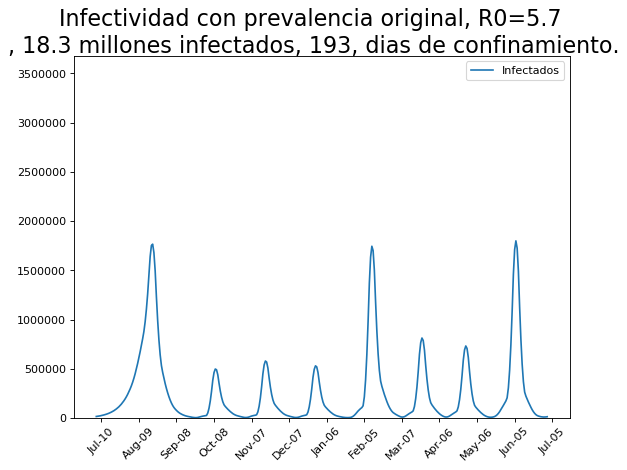

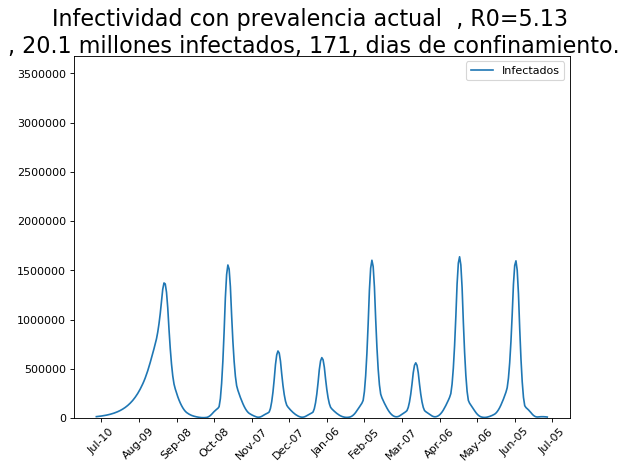

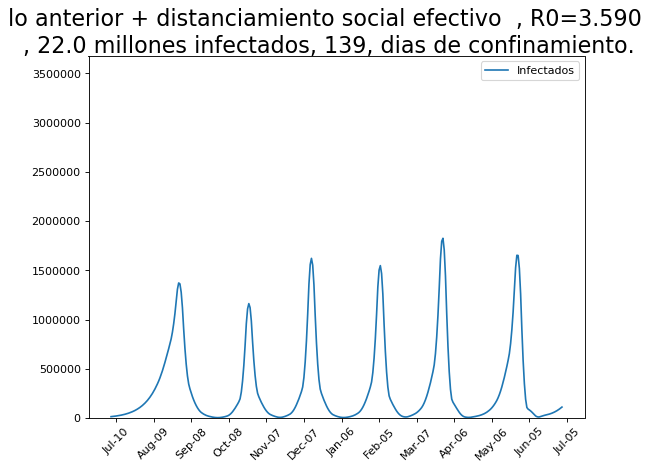

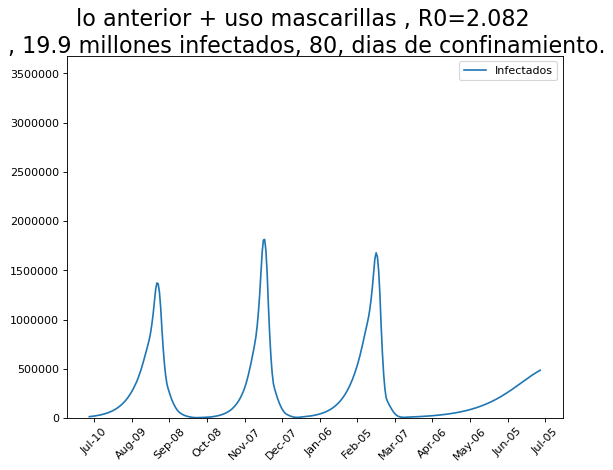

In [5]:
import pickle
from tqdm.notebook import tqdm

""" diccionario_R0s = {"Infectividad con prevalencia original, R0=5.7" : { R0 : 5.7, INITIAL_INFECTED_PEOPLE : 4500000} ,  
"lo anterior + distanciamiento social efectivo , R0=3.590"  : 3.590,   
"lo anterior + uso mascarillas , R0=2.082" : 2.082   ,                 
"lo anterior + temperaturas de verano , R0=1.707" : 1.702             
}

Infectividad primera ola , R0=5.7                           223383
lo anterior + distanciamiento social efectivo , R0=3.989     83430
lo anterior + uso mascarillas , R0=2.314                     20062
lo anterior + temperaturas de verano , R0=1.897              12331
lo anterior + confinamiento , R0=0.5                           875
"""
array_parametros = [
    { "descripcion" : "Infectividad con prevalencia actual  , R0=5.13"            , 'R0' : 5.7   , 'INITIAL_INFECTED_PEOPLE' : 4500000} 
 ]
array_parametros = [
    { "descripcion" : "Infectividad con prevalencia original, R0=5.7"             , 'R0' : 5.7   , 'INITIAL_INFECTED_PEOPLE' : 0} ,
    { "descripcion" : "Infectividad con prevalencia actual  , R0=5.13"            , 'R0' : 5.7   , 'INITIAL_INFECTED_PEOPLE' : 4500000} ,
    { "descripcion" : "lo anterior + distanciamiento social efectivo  , R0=3.590" , 'R0' : 3.989 , 'INITIAL_INFECTED_PEOPLE' : 4500000} ,
    { "descripcion" : "lo anterior + uso mascarillas , R0=2.082"                  , 'R0' : 2.314 , 'INITIAL_INFECTED_PEOPLE' : 4500000} ,
]

default_grid_thresolds ={"max_lockdown_thresold": [1800000, 
                                         1000000,
                                          750000,
                                          500000,
                                          250000,
                                          125000,
                                          62000,
                                         ],
                          "min_unlockdown_thresold": [5000, 10000,20000,40000,50000] } 


df_array = []

dict_default_values = {
    "INITIAL_RECOVERED_PEOPLE"                 : 10000                         ,
    "R0_min"                            :     0.5                       ,
    "max_lockdown_thresold"                        :  HEALT_SYSTEM_CAPACITY , 
    "min_unlockdown_thresold"                        :  5000                        ,
    "INITIAL_DATE"                 : '2020-07-01'                  ,
    "FINAL_DATE"                   : '2021-07-01'                  ,
    "outbreaks_detection_thresold"           :  7200                         , 
    "outbreaks_detection_efectivity_porcentage"      :  .25                           , 
    "imported_cases_unlockdown_weekly" :  50                           ,
    "imported_cases_lockdown_weekly"    :  20         
}

        
def get_lockdown_days(df_temp,min_unlockdown_thresold):
    df_interpolated=interpolate_dataframe(df_temp,'D')
    #return df_interpolated.shape[0] - (df_interpolated['Infected'] - df_interpolated['Infected'].shift(1) > 0).sum()  
    return ((df_interpolated['Infected'] - df_interpolated['Infected'].shift(1) < 0) & (df_interpolated['Infected'] > min_unlockdown_thresold)).sum()
max_lockdown_thresold = HEALT_SYSTEM_CAPACITY

for dict_escenario in array_parametros:
    ## Juntamos los valores por defecto, y los que cambian cada vez.
    param = {**dict_escenario, ** dict_default_values}
    #print(param)

    df_temp = pd.DataFrame()
    df_temp = calcular_prevision(
        FINAL_DATE                   = param['FINAL_DATE'                   ], 
        INITIAL_DATE                 = param['INITIAL_DATE'                 ], 
        INITIAL_RECOVERED_PEOPLE                 = param['INITIAL_RECOVERED_PEOPLE'                 ], 
        INITIAL_INFECTED_PEOPLE       = param['INITIAL_INFECTED_PEOPLE'       ],
        R0_max                            = param['R0'                                ], 
        R0_min                            = param['R0_min'                            ], 
        max_lockdown_thresold                        = param['max_lockdown_thresold'                        ], 
        min_unlockdown_thresold                        = param['min_unlockdown_thresold'                        ],
        imported_cases_lockdown_weekly    = param['imported_cases_lockdown_weekly'    ],
        imported_cases_unlockdown_weekly = param['imported_cases_unlockdown_weekly' ],
        DEBUG = False
    )
    df_temp
    
    df_temp = df_temp.astype(np.int64)
    df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
    infected_people = int(df_temp.astype(int).sum(axis=0))
    #print(param['descripcion'], df_temp.tail(1).index[-1],"suma: " , suma)
    df_array.append(df_temp) 
    DIAS_CONFINAMIENTO = get_lockdown_days(df_temp,param['min_unlockdown_thresold'])

    plt = Get_Chart(df=interpolate_dataframe(df_temp,'D'), 
                    title = param['descripcion'] +" \n, "+ str(infected_people/1000000)[:4] + " millones infectados, " +  str(DIAS_CONFINAMIENTO) + ", dias de confinamiento." ) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

    ax = plt.gca()
    ax.set_ylim([0,max_lockdown_thresold*2])
    param = {}
    
df  =  pd.concat(df_array)
#df_temp

In [6]:

import pickle

def simulation_save_to_file(objeto,nombre_fichero):
    pickle.dump(objeto, open(nombre_fichero, 'wb'))

def simulation_get_from_file(nombre_fichero):
    return pickle.load(open(nombre_fichero, 'rb'))




In [7]:
def get_results_singlechart_simulacion(results_array,criterio,puesto,mejores_resultados=True):
    df_results = pd.DataFrame(results_array)
    df_results.sort_values(criterio, inplace=True,ascending=mejores_resultados)
    row     = df_results.iloc[puesto]

    ### Get Parameters from simulation
    df_temp            = pd.DataFrame(row.df)
    suma               = row.infected_people
    lockdown_days = row.lockdown_days
    infected_people = '%.2f' % ( row.infected_people /1000000)
    waves     = row['waves']
    descripcion        = row['descripcion']
    umbral_maximo      = row['max_lockdown_thresold']
    umbral_minimo      = row['min_unlockdown_thresold']
    
    lugar = int(puesto) + int(1)
    df_array.append(df_temp) 
    #print (f"""criterio: {criterio}, puesto: {lugar}, descripcion {descripcion}, umbral_maximo: {umbral_maximo},umbral_minimo: {umbral_minimo}, 
    #infected_people: {infected_people}, lockdown_days: {lockdown_days}, waves: {waves})
    #""" )
    plt = Get_Chart(df=interpolate_dataframe(df_temp,'D'), 
                title  = f"""{descripcion}, {lugar}º en {criterio}""",
                xlabel = f"""infectados: {infected_people}, dias de confinamiento: {lockdown_days},Umbrales: ({umbral_maximo},{umbral_minimo}), olas {waves}""")

    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    return plt


In [8]:
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.dates as mdates

def Get_Chart2(df, title="default", xlabel="", ax=None,f=None, color='r'):
    if ax is None:
        ax = plt.gca()
    plt.axes(ax)
    for ca in df.columns:
        plt.plot(df[ca],color=color)
        plt.legend(df.columns)
        f.suptitle(title, fontsize=20)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.xticks(rotation=45)
    plt.gca().set_xlabel(xlabel,horizontalalignment='center')
    return plt


def get_results_multichart_simulacion2(f, axes,results_array,criterio,puesto,mejores_resultados=True,color='r'):
    """ Obtiene los n puestos mejores por un criterio.
    Selecciona los df y genera el array de graficos aosciado"""
    df_results = pd.DataFrame(results_array)
    for puesto in range(puesto): 
        df_results.sort_values(criterio, inplace=True,ascending=mejores_resultados)
        row     = df_results.iloc[puesto]

        ### Get Parameters from simulation
        df_temp            = pd.DataFrame(row.df)
        suma               = row.infected_people
        lockdown_days = row.lockdown_days
        infected_people = '%.2f' % ( row.infected_people /1000000)
        waves     = row['waves']
        descripcion        = row['descripcion']
        umbral_maximo      = row['max_lockdown_thresold']
        umbral_minimo      = row['min_unlockdown_thresold']
    
        lugar = int(puesto) + int(1)


        plt = Get_Chart2( ax=axes[puesto],f=f, df=interpolate_dataframe(df_temp,'D'), color=color,
                    title  = f"""{descripcion}, {lugar} mejores resultados en: {criterio}""",
                    xlabel = f"""infectados: {infected_people} mill.,  olas {waves}
dias de confinamiento: {lockdown_days},
Umbrales confinar/desconfinar:
({umbral_maximo},{umbral_minimo})""")

    return plt

def debug_get_results_multichart_simulacion2():
    for criterio in ['lockdown_days','waves','infected_people']:
        f, axes = plt.subplots(1 , 4 ,figsize=(16, 4), sharex=True)

        get_results_multichart_simulacion2(f=f, axes=axes,results_array=results_array,
                                 criterio =criterio,
                                puesto=4
                                )


In [9]:
import pickle
from tqdm.notebook import tqdm

default_grid_thresolds ={"max_lockdown_thresold": [1800000, 
                                         1000000,
                                          750000,
                                          500000,
                                          250000,
                                          125000,
                                          62000,
                                         ],
                          "min_unlockdown_thresold": [5000, 10000,20000,40000,50000] } 

def generate_results_simlation(dict_escenario, dict_default_values,parameter_grid = default_grid_thresolds) :
    df_array = []

    

    grid = ParameterGrid(parameter_grid)

     

    results_array = [ ]

    for grid_params in  tqdm(grid, desc= dict_escenario['descripcion']) : 
        params = {**grid_params, **dict_escenario, ** dict_default_values}
        
        if  params['max_lockdown_thresold'] <  params['min_unlockdown_thresold']          : continue
        if (params['max_lockdown_thresold'] / params['min_unlockdown_thresold']) <= 2.50  : continue
        if (params['max_lockdown_thresold'] - params['min_unlockdown_thresold']) < 25000  : continue        
        # Si hay una situacion donde no puedas ir ni hacia arriba ni hacia abajo
        if (params['max_lockdown_thresold'] / params['min_unlockdown_thresold']) <  params['R0'] / params['R0_min']   : continue
        ## Juntamos los valores por defecto, y los que cambian cada vez.
        #print(grid_params,dict_escenario["descripcion"])
        this_iteration_result = {}
        df_temp = pd.DataFrame()
        df_temp = calcular_prevision(
            INITIAL_DATE                 = params['INITIAL_DATE'                ], 
            FINAL_DATE                   = params['FINAL_DATE'                  ], 
            INITIAL_RECOVERED_PEOPLE                 = params['INITIAL_RECOVERED_PEOPLE'                ], 
            INITIAL_INFECTED_PEOPLE       = params['INITIAL_INFECTED_PEOPLE'      ],
            R0_max                            = params['R0'                               ], 
            R0_min                            = params['R0_min'                           ], 
            max_lockdown_thresold                        = params['max_lockdown_thresold'                       ], 
            min_unlockdown_thresold                        = params['min_unlockdown_thresold'                       ],
            imported_cases_lockdown_weekly    = params['imported_cases_lockdown_weekly'   ],  
            imported_cases_unlockdown_weekly = params['imported_cases_unlockdown_weekly']  
            
        )
        # Prepare results
        # Dataframe level
        df_temp = df_temp.astype(np.int64)
        df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
        # Calculate results
        infected_people = int(df_temp.astype(int).sum(axis=0))
        df_temp['Diferencia'] =  df_temp['Infected'] - df_temp['Infected'].shift(1)

        lockdown_days = get_lockdown_days(df_temp,params['min_unlockdown_thresold'])

        waves = (( df_temp['Diferencia'] < 0) & (df_temp['Diferencia'].shift(1) > 0 )  ).sum()   
        # Store results
        this_iteration_result['escenario']                         = dict_escenario["escenario"]
        this_iteration_result['descripcion']                       = dict_escenario["descripcion"]
        this_iteration_result['max_lockdown_thresold']                        = params['max_lockdown_thresold']
        this_iteration_result['min_unlockdown_thresold']                        = params['min_unlockdown_thresold']
        this_iteration_result['lockdown_days']                = lockdown_days
        this_iteration_result['waves'    ]                = waves
        this_iteration_result['infected_people']                = infected_people
        this_iteration_result['R0']                                = params['R0']
        this_iteration_result['R0_min']                            = params['R0_min']
        this_iteration_result['INITIAL_DATE']                 = params['INITIAL_DATE']
        this_iteration_result['FINAL_DATE']                   = params['FINAL_DATE']
        this_iteration_result['INITIAL_RECOVERED_PEOPLE']                 = params['INITIAL_RECOVERED_PEOPLE']
        this_iteration_result['INITIAL_INFECTED_PEOPLE']       = params['INITIAL_INFECTED_PEOPLE']
        this_iteration_result['imported_cases_lockdown_weekly']    = params['imported_cases_lockdown_weekly']
        this_iteration_result['imported_cases_unlockdown_weekly'] = params['imported_cases_unlockdown_weekly']
        this_iteration_result['df']                                = df_temp['Infected']
          
        #print(this_iteration_result)
        results_array.append(this_iteration_result) 
    return results_array

def simulation_save_to_file(objeto,nombre_fichero):
    pickle.dump(objeto, open(nombre_fichero, 'wb'))



def Generar_Datos_Conjunto_Escenarios(array_parametros,dict_default_values,title):
    display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
    
    all_results_array=[]
    # Por cada escenario, generamos las respuestas, y obtenemos las mejores por     lockdown_days','waves','infected_people'
    for i,escenario in  tqdm(enumerate(array_parametros), desc="Procesando escenarios") :
        results_array = []    
        results_array = generate_results_simlation(escenario,dict_default_values)
        all_results_array += results_array
        #print(" Escenario: "+ escenario['descripcion'])
        simulation_save_to_file(results_array,"/tmp/simulacion_"+str(i)+".pickle")
    simulation_save_to_file(all_results_array,"/tmp/"+title+"last_scenary_all.pickle")
    

    return all_results_array


def Generar_Graficos(results_array,escenario,criterio,color):
    f, axes = plt.subplots(1 , 4 ,figsize=(16, 4), sharex=True)

    get_results_multichart_simulacion2(f=f, axes=axes,results_array=results_array,
                             criterio =criterio,
                            puesto=4,color=color
                            )

def Extraer_Escenario_From_Resultados(all_results_array,escenario,criterio,elementos=5):
    """Extraer los resultados de un escenario y un criterio"""
    all_results_df   = pd.DataFrame(all_results_array)
    df_escenario     = all_results_df.filter_on(f"""descripcion == '{escenario}'"""  )
    array_criterios  = [ ]
    criterios_order  = [ ]
    if criterio == 'infected_people' :
        array_criterios      =  [ 'infected_people', 'waves']
        array_criterio_order =  [ True, True ]
    elif  criterio == 'lockdown_days' :
        array_criterios      =  [ 'lockdown_days' ,'infected_people' ]
        array_criterio_order =  [ True, True]
    elif criterio == 'waves' :
        array_criterios      =  [ 'waves', 'infected_people' ]
        array_criterio_order =  [ True, True] 
    #print("ordenamos ",escenario, array_criterios,array_criterio_order)
    df_escenario.sort_values(by = array_criterios,ascending=array_criterio_order ,inplace=True)
    return df_escenario.head(elementos)    

from matplotlib import cm,colors
def Mostrar_Resultados_Conjunto_Escenarios(all_results_array, ordenar='criterio'):
    # Extraemos resultados
    cmap = colors.ListedColormap(['tab:blue','tab:green','tab:brown'])    
    lista_escenarios = pd.DataFrame(all_results_array).descripcion.unique()
    if  ordenar == 'criterio': 
        ARRAY_CRITERIO=['infected_people','lockdown_days','waves']
        for i,criterio in enumerate(ARRAY_CRITERIO):
            color = cmap(i)
            for escenario in  lista_escenarios:
                escenario_results_array = Extraer_Escenario_From_Resultados(all_results_array,escenario,criterio,elementos=5)  
                Generar_Graficos(escenario_results_array,escenario,criterio,color=color)
    else :
        for escenario in  lista_escenarios:
            ARRAY_CRITERIO=['infected_people','lockdown_days','waves']
            for i,criterio in enumerate( ARRAY_CRITERIO):
                color = cmap(i)
                escenario_results_array = Extraer_Escenario_From_Resultados(all_results_array,escenario,criterio,elementos=5)  
                Generar_Graficos(escenario_results_array,escenario,criterio,color=color)       



<h2>Generador de resultados.</h2>

Por cada escenario, lo probamos con un grid de parámetros configurables. 
Es decir, que calculamos cada escenario múltiples veces usando distintos parámetros de confinamiento y desconfinamiento, generando un array de resultados posibles por cada escenario.

A continuación escogeremos por cada escenario, aquellos juegos de parámetros que optimicen los resultados de nº de infectados, nº de días confinados, nº de olas.


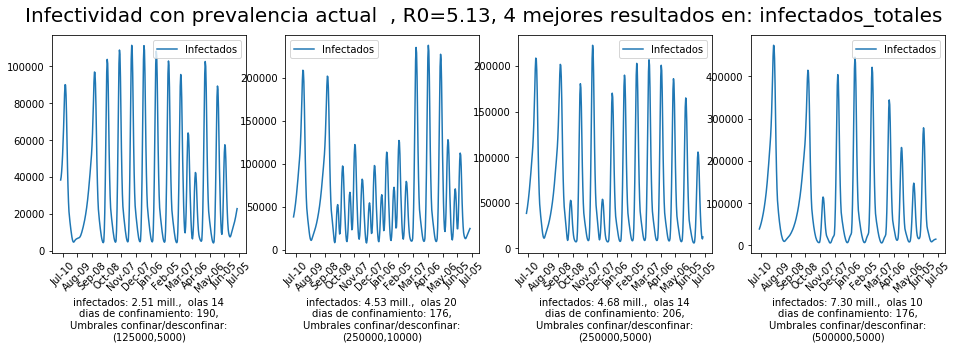

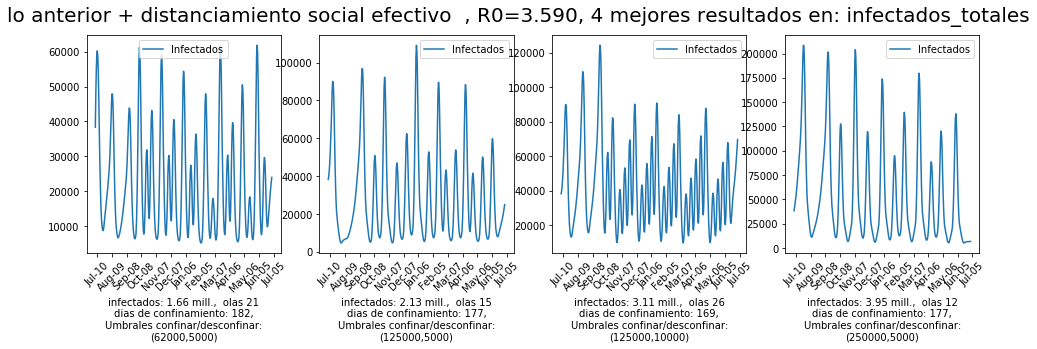

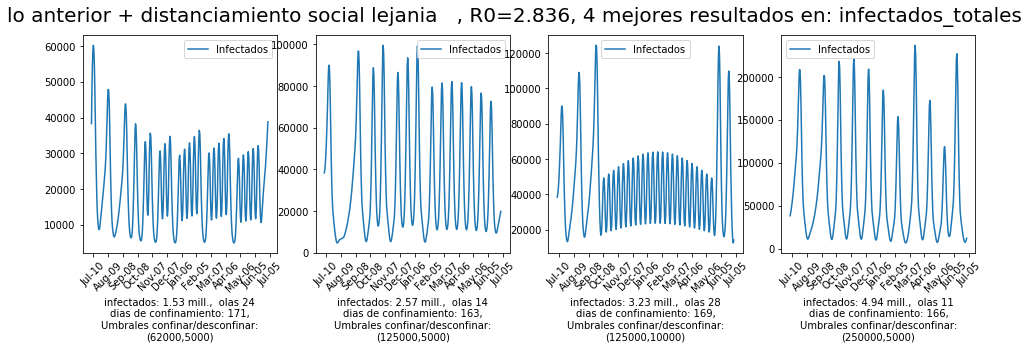

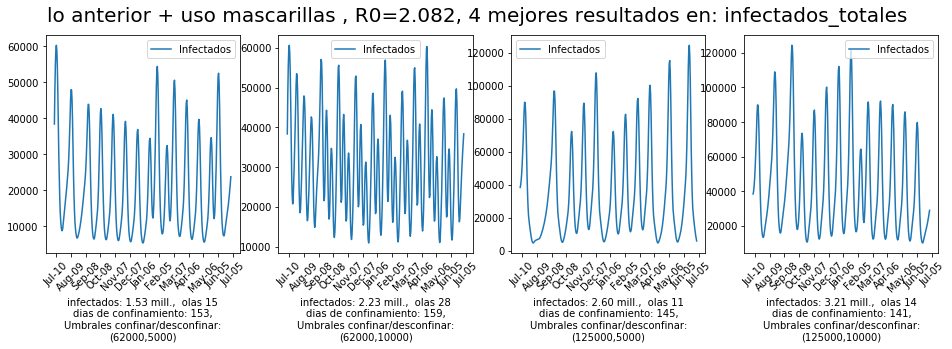

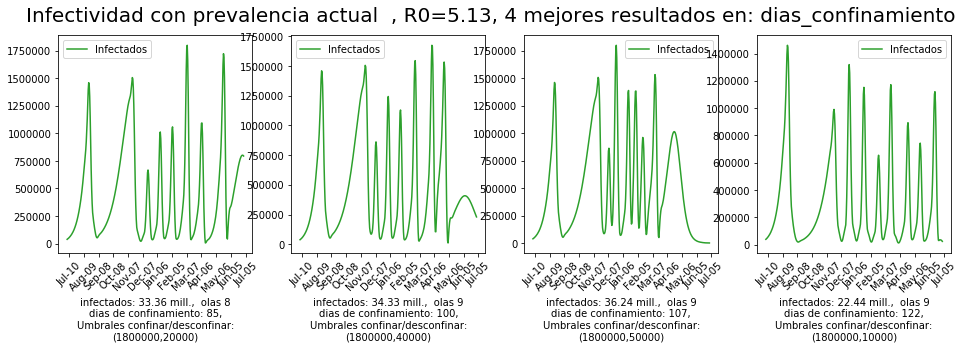

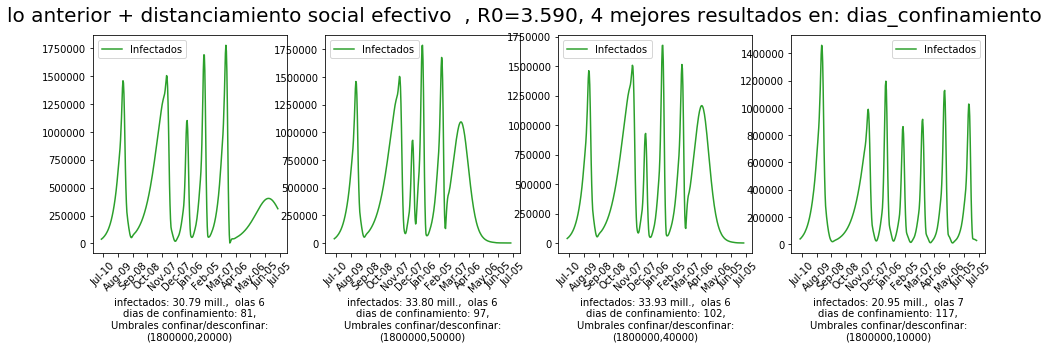

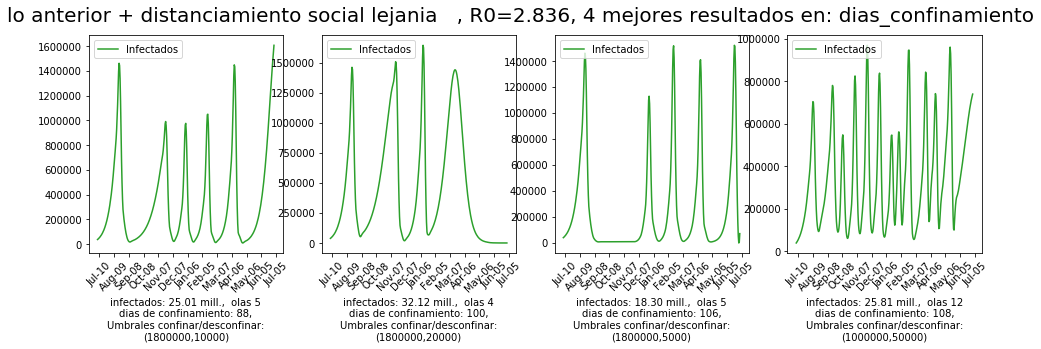

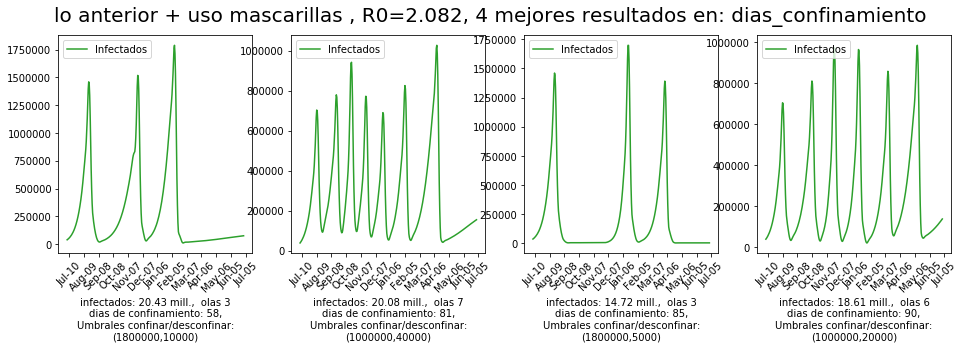

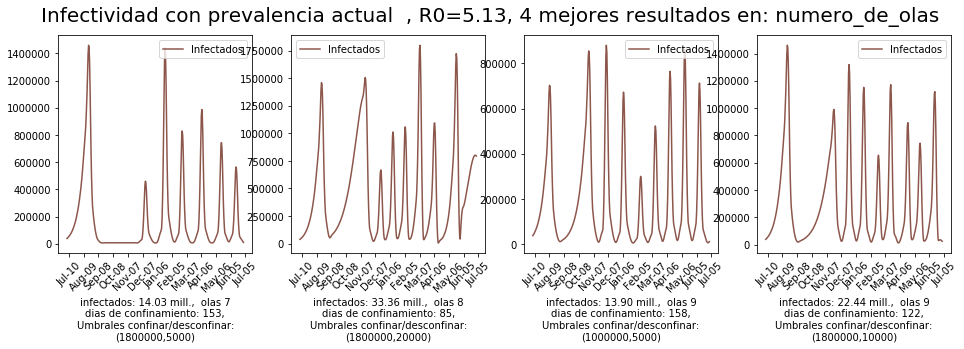

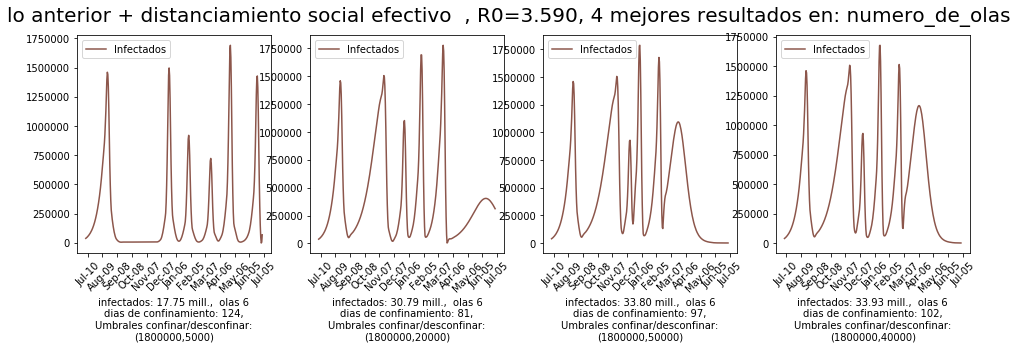

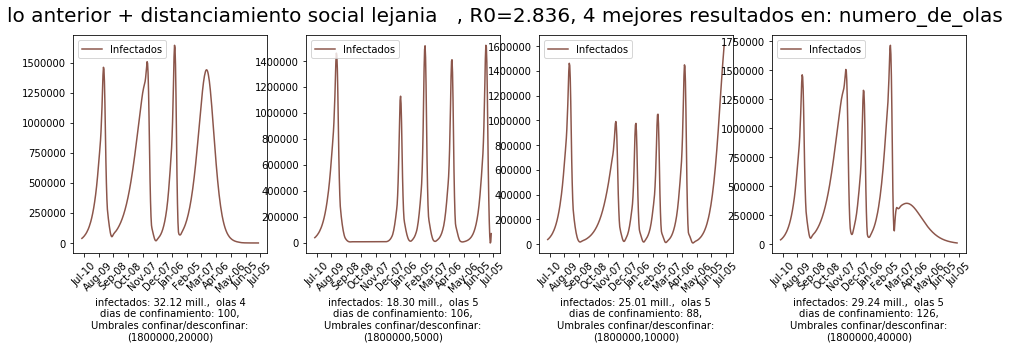

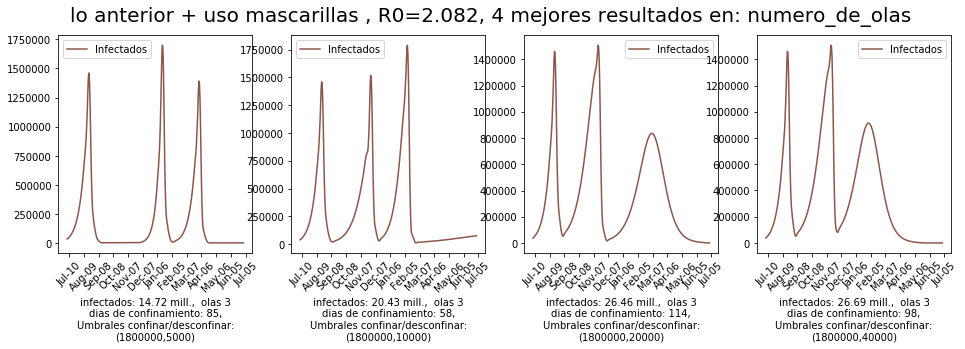

In [10]:
array_parametros_estudio_mascarillas = [
  #  { "descripcion" : "Infectividad con prevalencia original, R0=5.7"             , 'R0' : 5.7   , 'INITIAL_INFECTED_PEOPLE' : 0} ,
    { "escenario": "mascarillas" , "descripcion" : "Infectividad con prevalencia actual  , R0=5.13"            , 'R0' : 5.7     } ,
    { "escenario": "mascarillas" , "descripcion" : "lo anterior + distanciamiento social efectivo  , R0=3.590" , 'R0' : 3.989   } ,
    { "escenario": "mascarillas" , "descripcion" : "lo anterior + distanciamiento social lejania   , R0=2.836" , 'R0' : 3.1515  } ,
    { "escenario": "mascarillas" , "descripcion" : "lo anterior + uso mascarillas , R0=2.082"                  , 'R0' : 2.314   } ,
]

dict_default_values ={
    'FINAL_DATE'                   : '2021-07-01',
    'INITIAL_DATE'                 : '2020-07-01',
    'INITIAL_INFECTED_PEOPLE'       :  4500000    , 
    "R0_min"                            :  0.43       ,
    "INITIAL_RECOVERED_PEOPLE"                 :  25000      ,
    "outbreaks_detection_thresold"           :  7200       , 
    "outbreaks_detection_efectivity_porcentage"      :  .25        ,    
    "imported_cases_lockdown_weekly"    :  25         , 
    "imported_cases_unlockdown_weekly" :  50 
    }

mascarillas = Generar_Datos_Conjunto_Escenarios(array_parametros_estudio_mascarillas,dict_default_values,"Estudio de Mascarillas")
Mostrar_Resultados_Conjunto_Escenarios(mascarillas)


## Segunda hipotesis : Airborne

La hipotesis a estudiar aquí, es que el virus sea aerotransportado

Es decir, que la capacidad principal de propagación del virus sea a traves del aire.

De ser esto cierto, las mascarillas jugarían un papel fundamental.

Esta hipotesis sigue este estudio https://www.pnas.org/content/early/2020/06/10/2009637117, y las R0 son calculadas a partir del mismo 

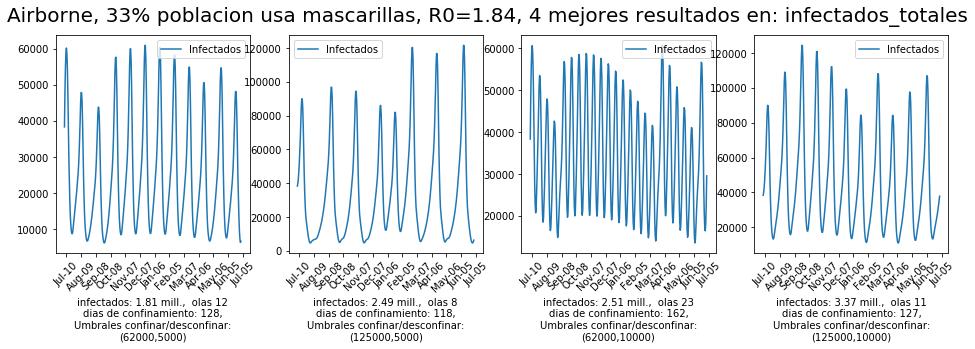

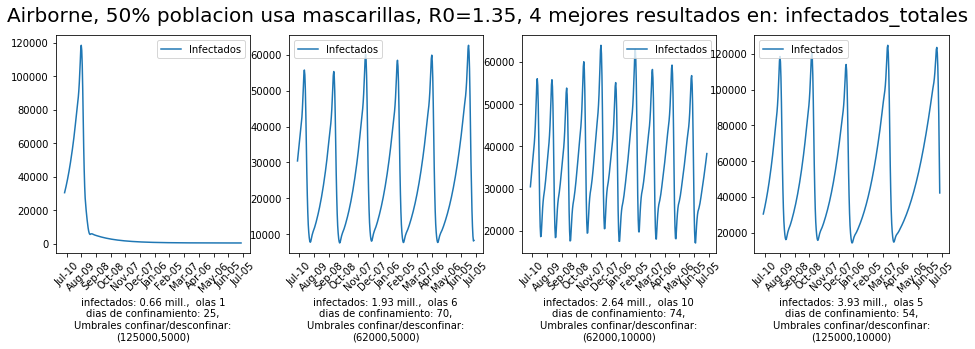

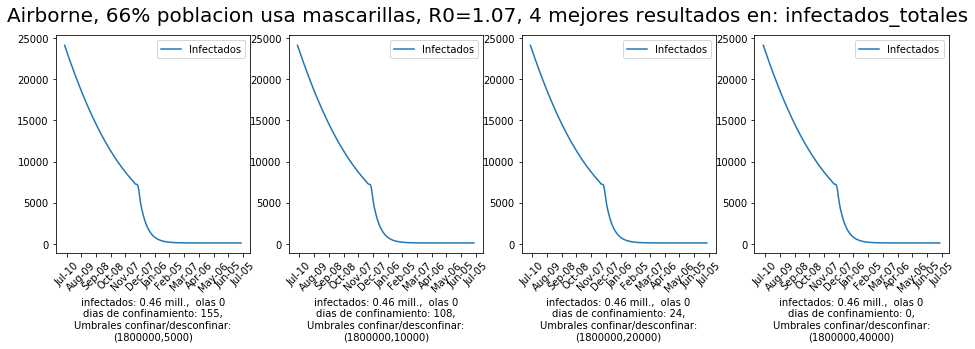

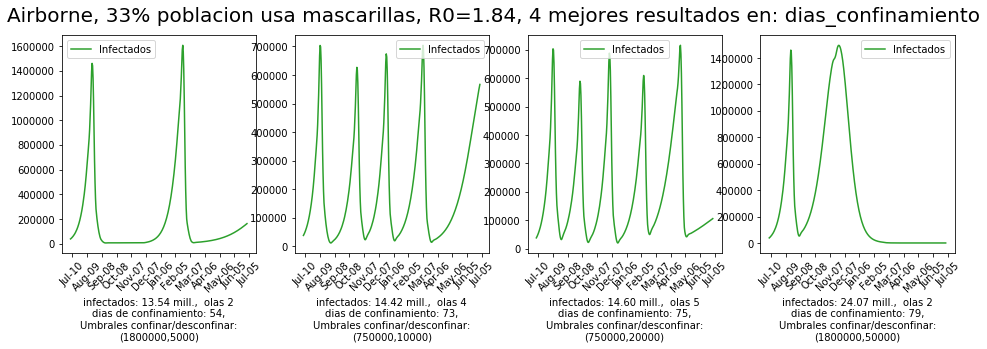

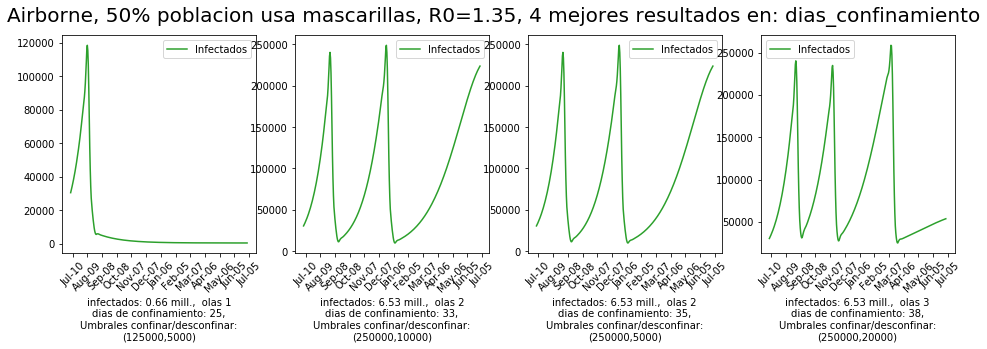

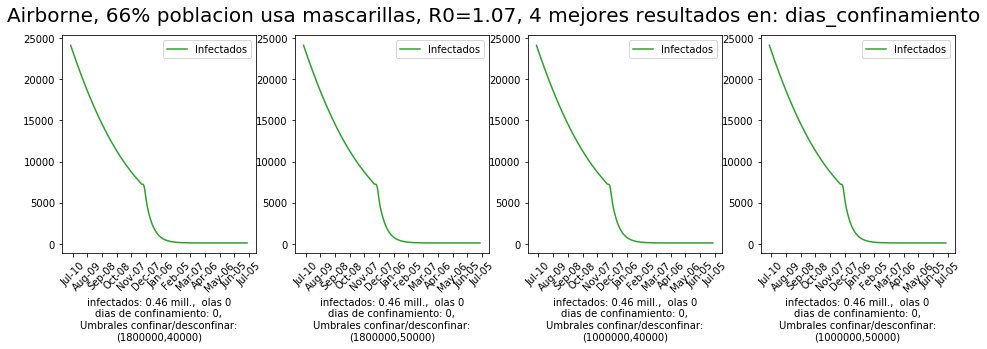

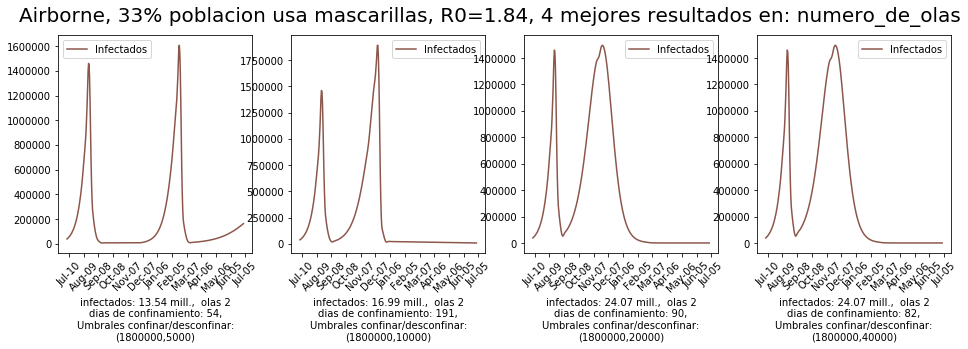

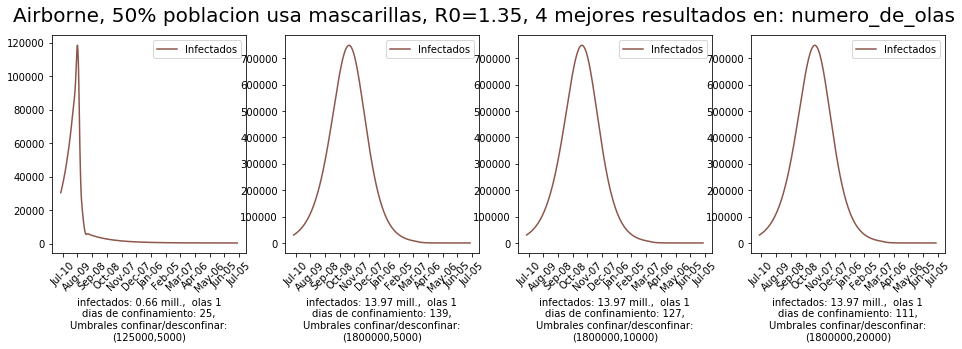

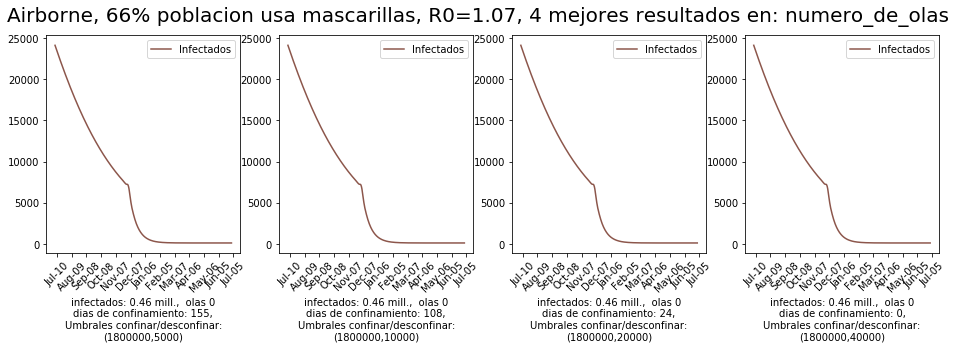

In [11]:
array_parametros_airborne = [
    { "escenario": "airborne" , "descripcion" : "Airborne, 33% poblacion usa mascarillas, R0=1.84" , 'R0' : 1.84 } ,
    { "escenario": "airborne" , "descripcion" : "Airborne, 50% poblacion usa mascarillas, R0=1.35" , 'R0' : 1.35 } ,
    { "escenario": "airborne" , "descripcion" : "Airborne, 66% poblacion usa mascarillas, R0=1.07" , 'R0' : 1.07 } ,
    
]
dict_default_values ={
 'FINAL_DATE'                   : '2021-07-01' ,
 'INITIAL_DATE'                 : '2020-07-01' ,
 'INITIAL_INFECTED_PEOPLE'       : 4500000      ,
 'R0_min'                            : 0.43         ,
 'INITIAL_RECOVERED_PEOPLE'                 : 25000        ,
 'GENERACIONES_SUBIDA'               : 1           , 
 'GENERACIONES_BAJADA'               : 1           ,
 "outbreaks_detection_thresold"           :  7200        , 
 "outbreaks_detection_efectivity_porcentage"       :  .25        , 
 "imported_cases_lockdown_weekly"    :  25          , 
 "imported_cases_unlockdown_weekly" :  50 }

airborne = Generar_Datos_Conjunto_Escenarios(array_parametros_airborne,dict_default_values,"Analisis airborne medio de transporte")
Mostrar_Resultados_Conjunto_Escenarios(airborne)


## Conclusiones del estudio de la hipotesis "Airbone", que el virus es aerotransportado.

- Las cifras de R0 de este estudio son mas bajas que las de otros, y <string>abundan en la importancia de las mascarillas frente al confinamiento.</string>


- De ser veraz el estudio, <string>basta con que dos de cada 3 personas llevaran mascarillas, para que la epidemia se autoextinguiera</string> - pero si baja del 66% al 50 %, ya no se extingue y habría al menos 2 millones de infectados. 


- En este escenario, un 13% de personas que lleven mascarilla es la diferencia entre que vivan o mueran unas 5.000 personas.


## Hipotesis vacations:  ¿ Habrá ola durante el verano. ?

Vamos a extrapolar los datos de muertes en Madrid, para estimar el nº de infectados, y probar con distintos valores de R0 durante el verano para saber si habrá segunda ola en verano.


In [12]:
# Ver los datos del notebook Madrid_Pain_Graphs
MADRID_MUERTES=15000
MADRID_CASOS_PCR=323000
MADRID_CASOS_POR_PREVALENCIA=7000000*0.1

MADRID_CASOS_TOTALES_POR_MUERTE=MADRID_CASOS_POR_PREVALENCIA/MADRID_MUERTES
#MADRID_CASOS_TOTALES_POR_MUERTE
#46.666666666666664
MADRID_MUERTES_DIARIAS_MA=13
ESTIMACION_CASOS_MADRID=MADRID_MUERTES_DIARIAS_MA*MADRID_CASOS_TOTALES_POR_MUERTE
#ESTIMACION_CASOS_MADRID
#606.6666666666666
# MADRID REPRESENTA 1/3 CASOS TOTALES. ASI QUE

ESTIMACION_CASOS_ESPAÑA=ESTIMACION_CASOS_MADRID*3
ESTIMACION_CASOS_ESPAÑA
#1820
ESTIMACION_CASOS_ESPAÑA_DIARIA=ESTIMACION_CASOS_MADRID*3
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=ESTIMACION_CASOS_ESPAÑA_DIARIA*5
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION
#9100
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=9100
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION

9100

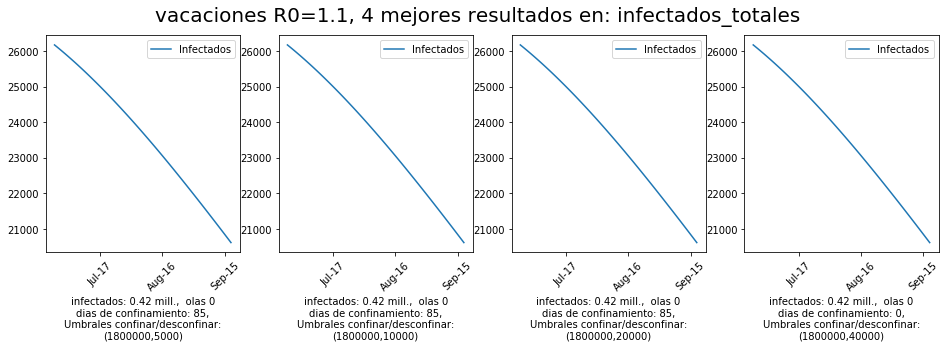

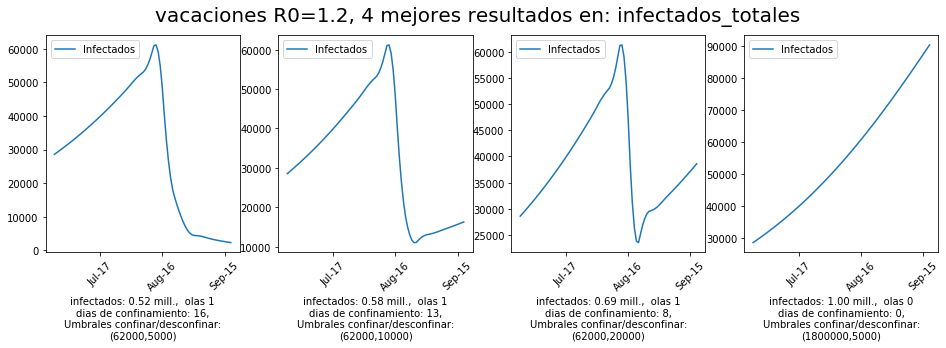

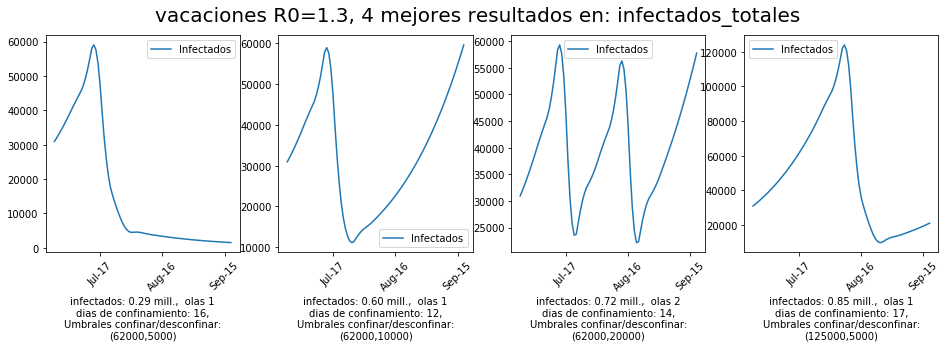

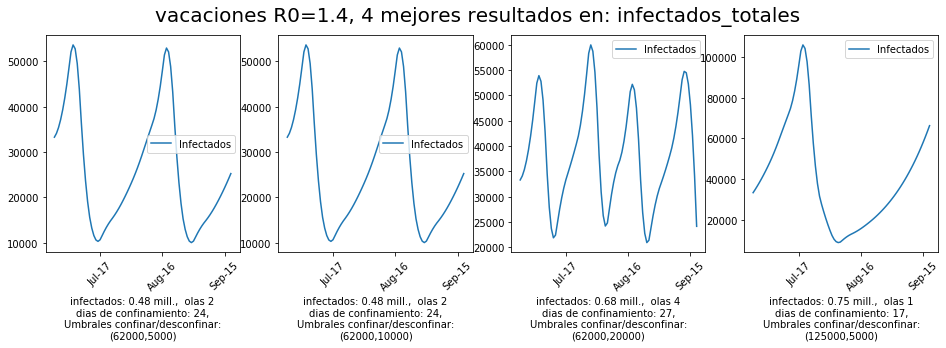

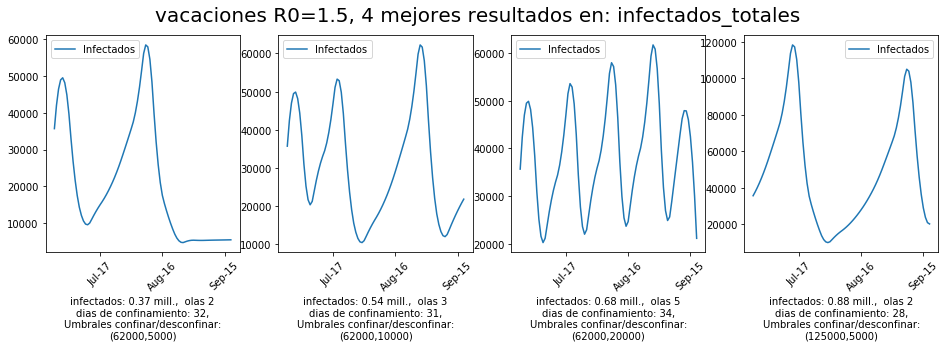

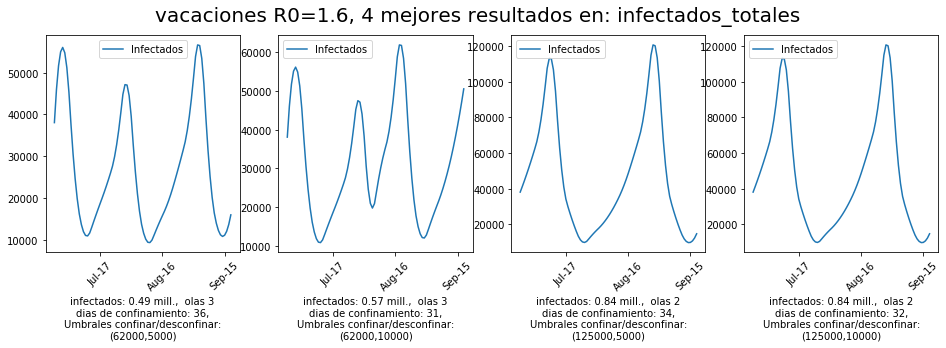

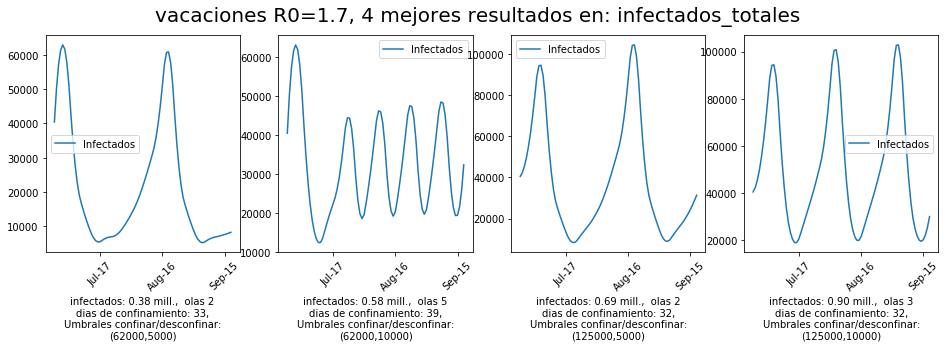

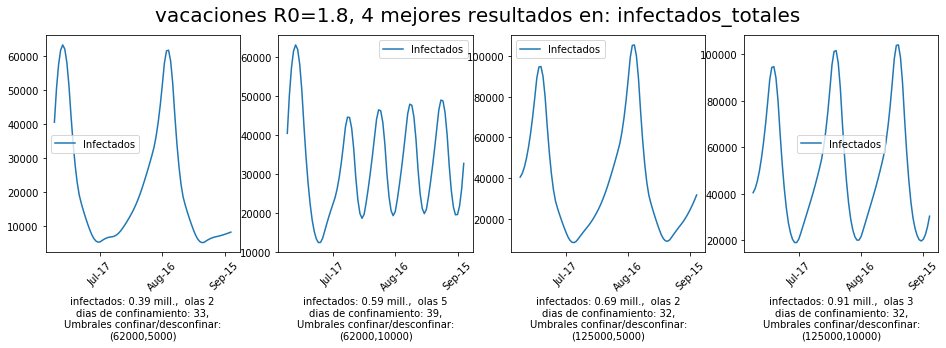

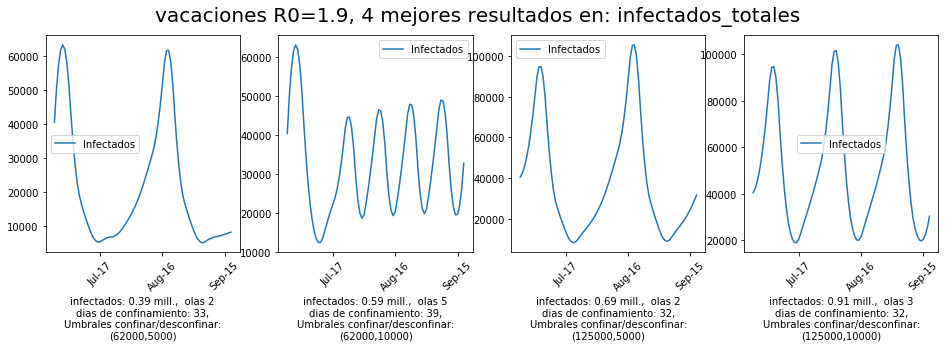

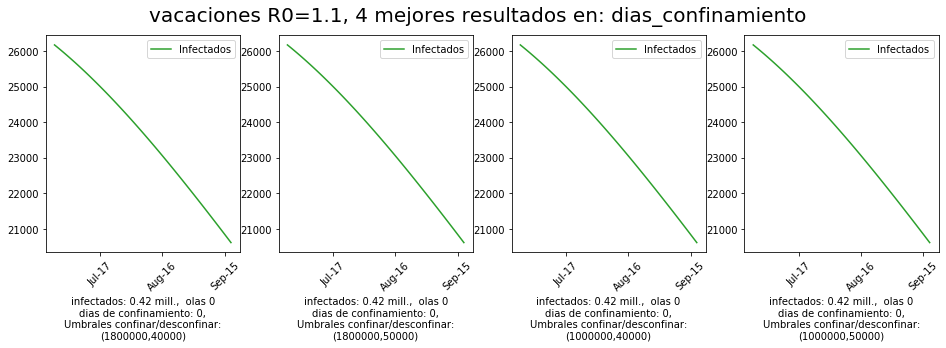

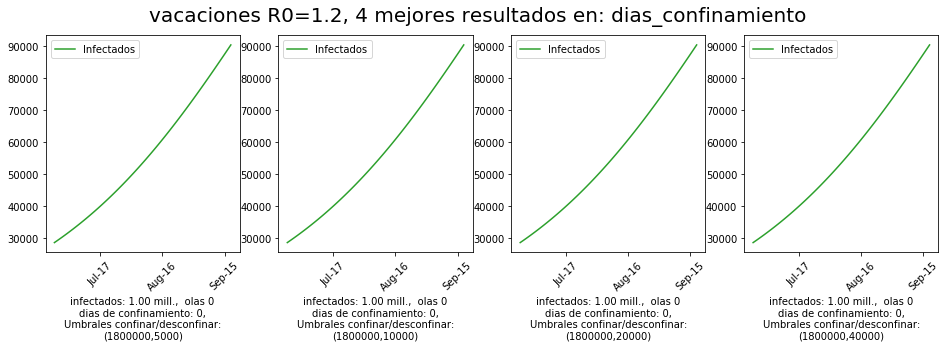

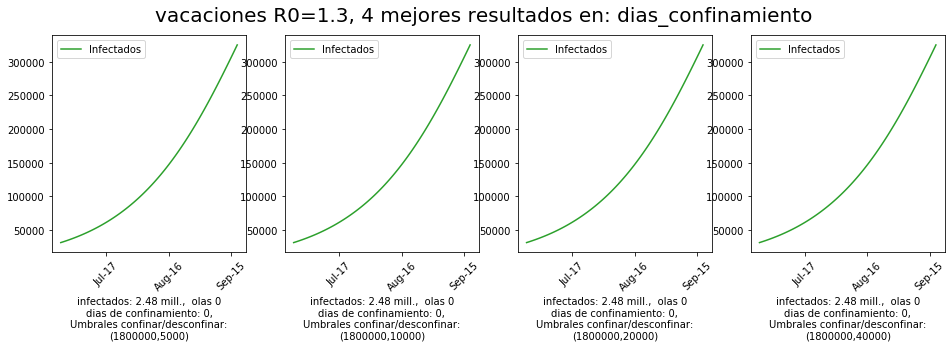

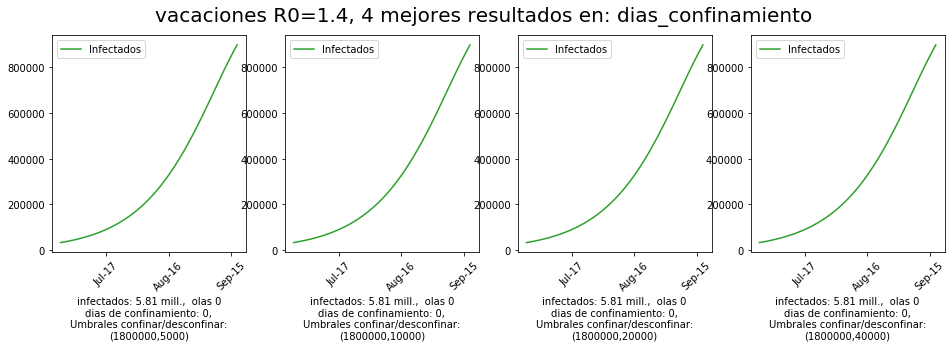

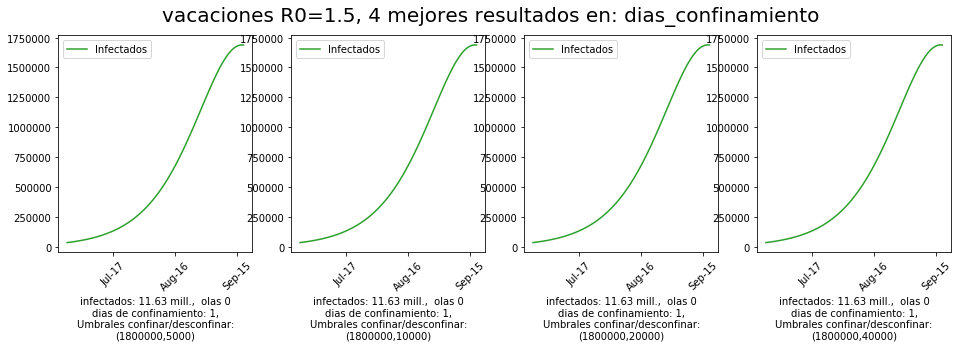

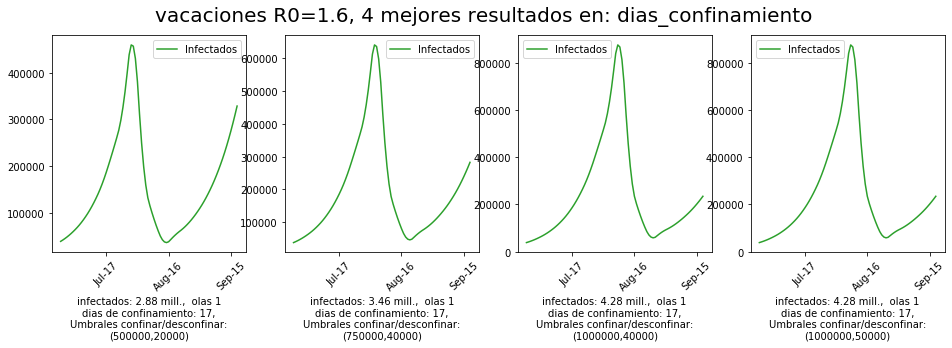

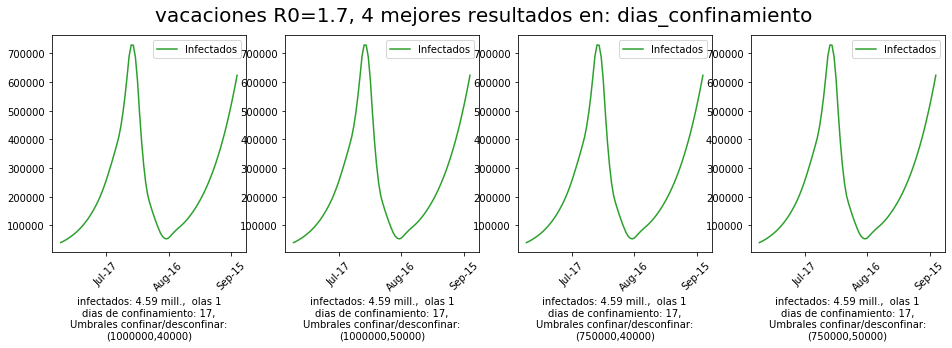

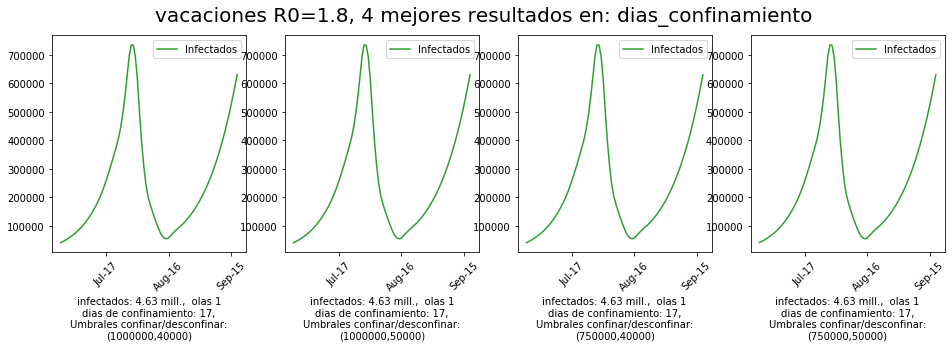

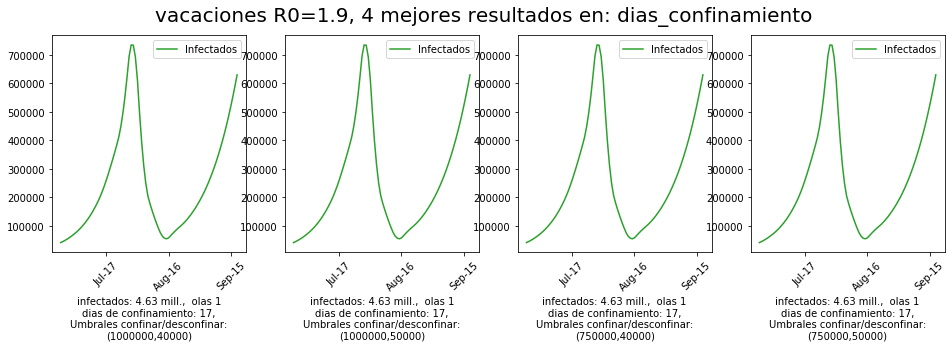

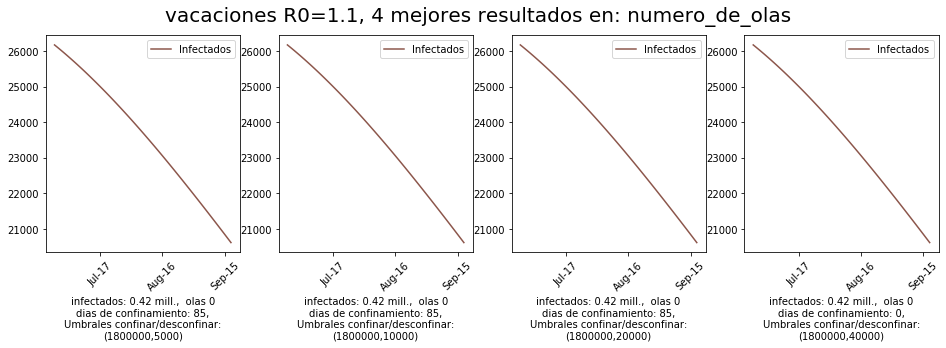

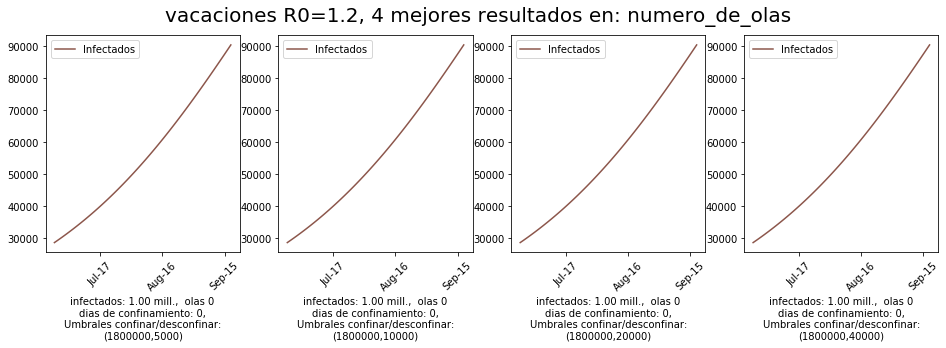

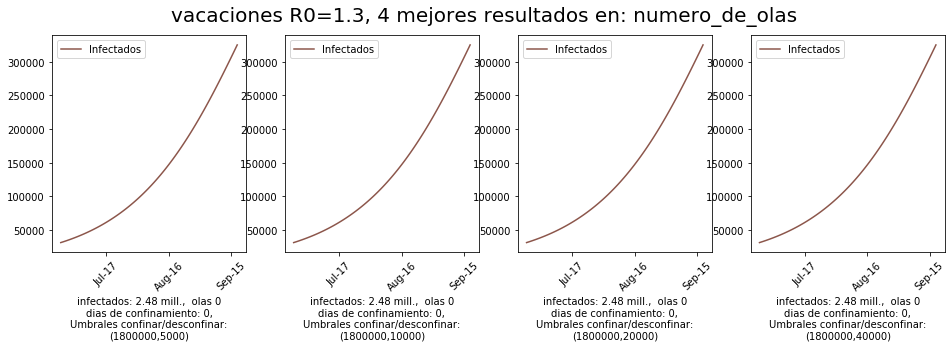

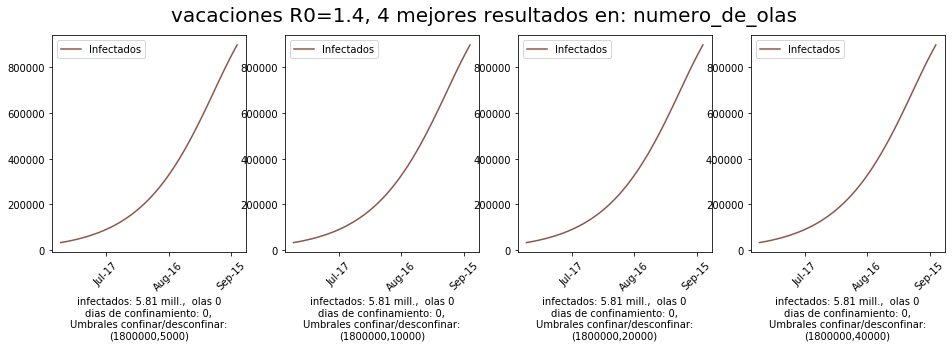

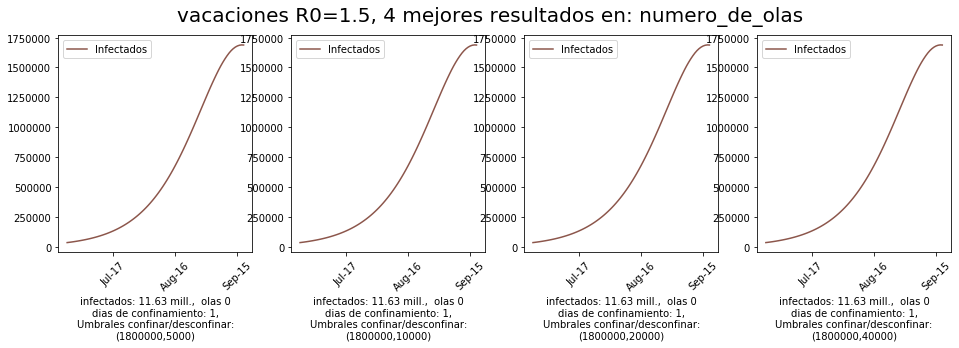

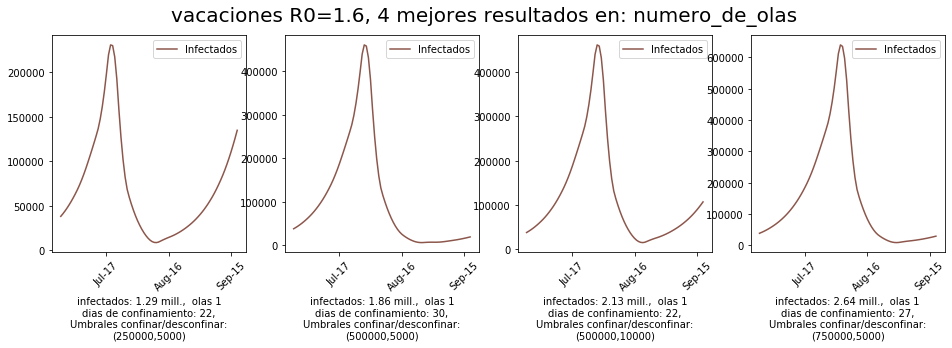

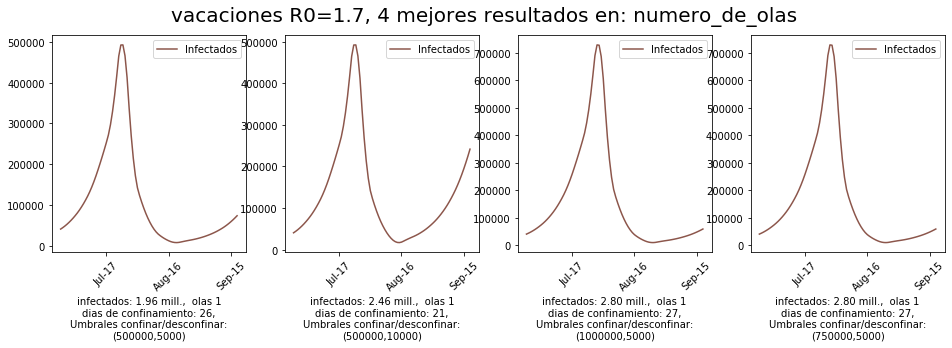

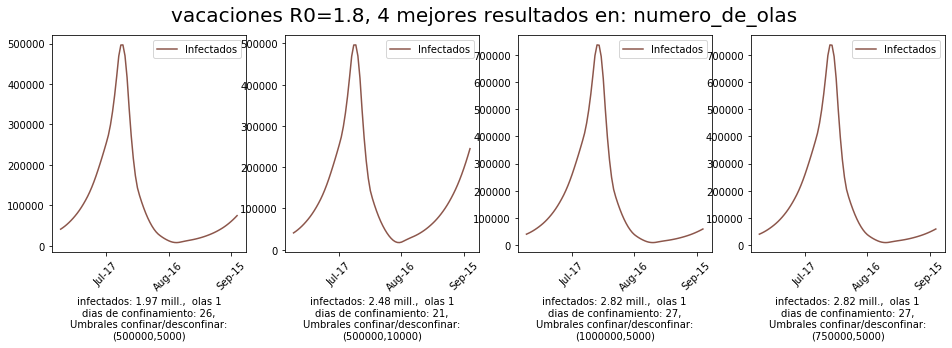

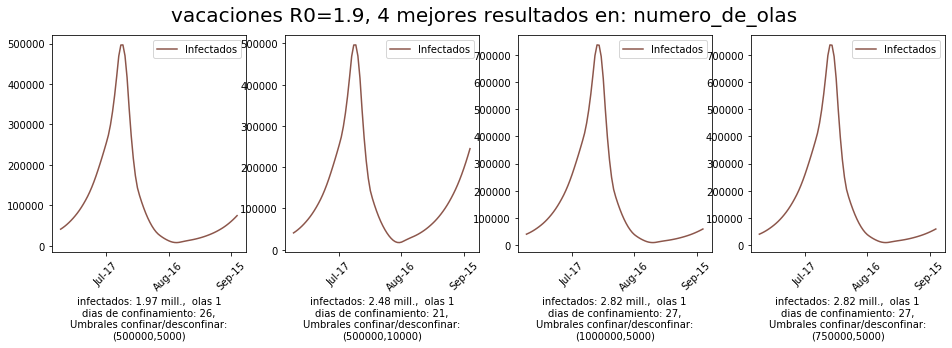

In [13]:
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=26400
array_parametros_estudio_vacations = [ 
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.1" ,"RO_calor" : 1.10 ,  "R0" : 1.1} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.2" ,"RO_calor" : 1.20  , "R0" : 1.2} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.3" ,"RO_calor" : 1.30  , "R0" : 1.3} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.4" ,"RO_calor" : 1.40  , "R0" : 1.4} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.5" ,"RO_calor" : 1.50  , "R0" : 1.5} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.6" ,"RO_calor" : 1.60  , "R0" : 1.6} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.7" ,"RO_calor" : 1.70  , "R0" : 1.7} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.8" ,"RO_calor" : 1.80  , "R0" : 1.8} ,
 { "escenario": "vacations" , "descripcion" : "vacations R0=1.9" ,"RO_calor" : 1.90  , "R0" : 1.9} 
]


dict_default_values = {
    "R0_min" : 0.5,
    "INITIAL_RECOVERED_PEOPLE" : ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION  ,
    "INITIAL_DATE" : '2020-06-20'  ,
    "FINAL_DATE"   : '2020-09-20'  ,
    'GENERACIONES_SUBIDA' : 1 , 'GENERACIONES_BAJADA' : 1,
    'INITIAL_INFECTED_PEOPLE' : 4500000  ,
    'imported_cases_unlockdown_weekly' : 50,
     "imported_cases_lockdown_weekly"    :  20     ,
    "outbreaks_detection_thresold"           :  7200                         , 
    "outbreaks_detection_efectivity_porcentage"      :  .25                          
    }
        
vacations = Generar_Datos_Conjunto_Escenarios(array_parametros_estudio_vacations,dict_default_values,"Vacaciones")
Mostrar_Resultados_Conjunto_Escenarios(vacations)


### Conclusiones del Escenario: vacations

Este modelo es <strong>muy sensible a las condiciones iniciales</strong>:

- Cuando empiezan a subir las <strong>temperaturas</strong>.

- El uso de <strong>mascarillas</strong>.  

- La capacidad de <strong>detectar y aislar nuevos brotes</strong>.

- Cuantos <strong>casos importados</strong> tengamos.

Si se cumplen <strong>las condiciones</strong>, es posible que aguantasemos el verano <strong>sin confinamientos</strong>, si logramos mantener el R0<1.3.

<strong>Aún en el caso de que no lográramos mantener bajo el R0</strong>, si hicieramos confinamiento, y fueramos lo bastante previsores <strong>con los umbrales de confinamiento</strong> y desconfinamiento, podriamos <strong>mantener bajo el número de infectados</strong> - medio millón de infectados, unas 1200 muertes.



## Hipotesis: Datos de Madrid

Esta hipotesis traslada los datos de R0 la comunidad de Madrid a toda España.


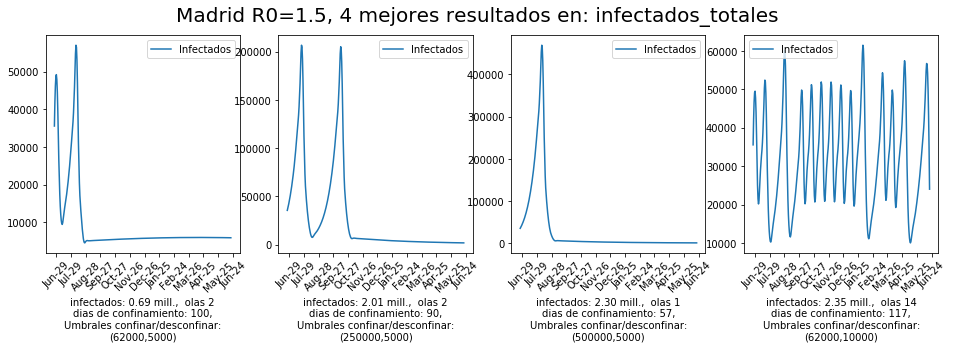

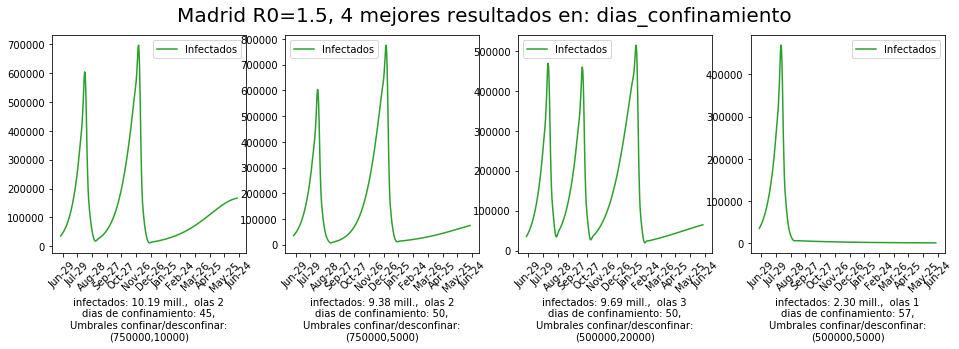

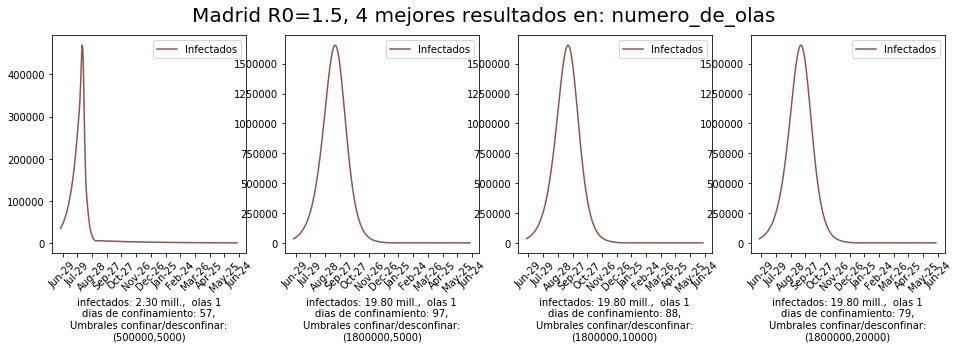

In [14]:
# Caso Datos de Madrid
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=26400

array_parametros_estudio_vacations = [ 
 { "escenario"        : "Madrid" , 
  "descripcion"       : "Madrid R0=1.5" ,
  "RO_calor"          : 1.23  ,
  "INITIAL_RECOVERED_PEOPLE" : ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION,
  "R0"                : 1.4952 } 
]




dict_default_values = {
    "R0_min" : 0.5,
    "INITIAL_DATE" : '2020-06-20'  ,
    "FINAL_DATE"   : '2021-06-20'  ,
    'GENERACIONES_SUBIDA' : 1 , 'GENERACIONES_BAJADA' : 1,
    'INITIAL_INFECTED_PEOPLE' : 4500000  ,
    "outbreaks_detection_thresold"           :  7200                         , 
    "outbreaks_detection_efectivity_porcentage"       :  .25                         , 
    "imported_cases_unlockdown_weekly" :  50                           ,
    "imported_cases_lockdown_weekly"    :  20   
    }

        
default_grid_thresolds ={"max_lockdown_thresold": [1800000, 
                                         1000000,
                                          750000,
                                          500000,
                                          250000,
                                          125000,
                                          62000,
                                         ],
                          "min_unlockdown_thresold": [ 10000,20000,40000,50000] } 

madrid = Generar_Datos_Conjunto_Escenarios(array_parametros_estudio_vacations,dict_default_values,"Madrid")
Mostrar_Resultados_Conjunto_Escenarios(madrid)



### Conclusiones del Escenario: Madrid

Este escenario es interesante, porque muestra que <strong>si se consigue bajar los casos por debajo de cierto umbral</strong>, ocasiona que <strong>la detección de brotes</strong> sea capaz de <strong>prevenir nuevas olas</strong>. 

<strong>Si se supera el umbral</strong>, como cuando se supera la masa crítica de un sistema, <strong>se produce una ola</strong> epídemica.

Lo interesante de este escenario es que sugiere que en <strong>algunas comunidades se podrían prevenir nuevas olas, pero en otras comunidades sean imposibles de evitar</strong>. 


## Hipótesis : Casos importados.

Esta hipotesis coge los datos de la comunidad de Madrid, y estudia la variación, al modificar el nº de casos importados.

Se pretende comprender el impacto de abrir las fronteras, y permitir la llegada de turistas.


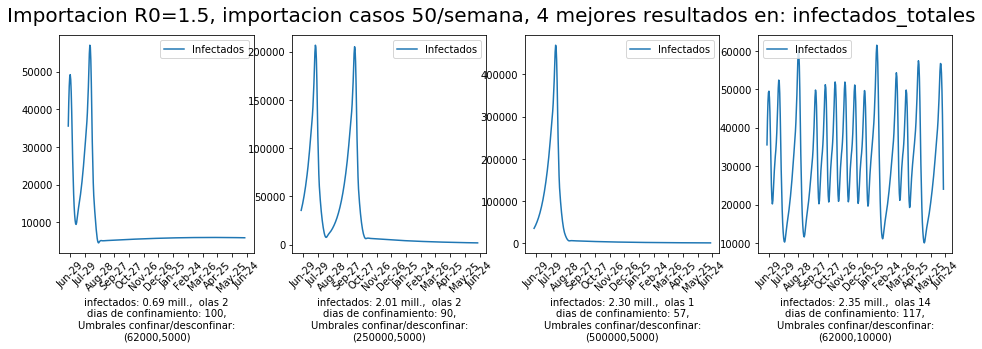

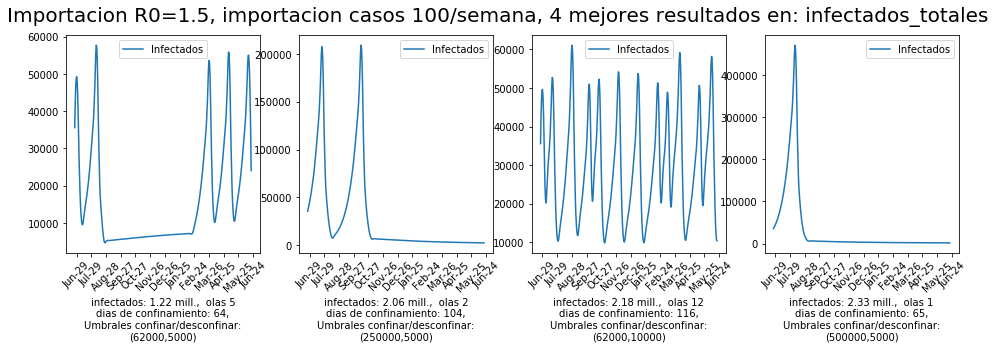

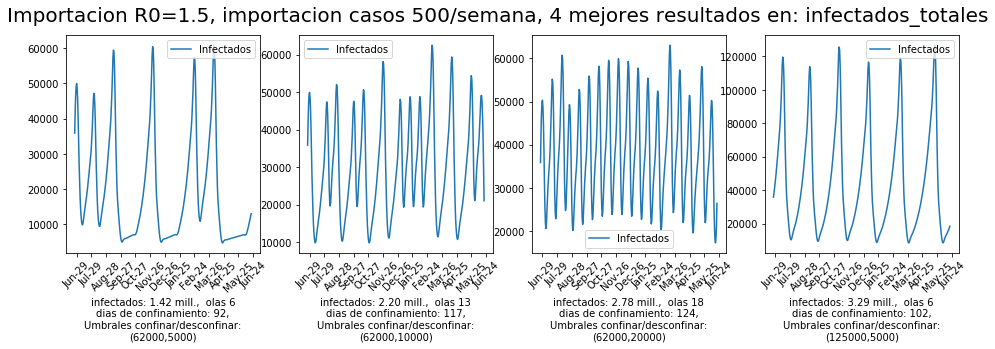

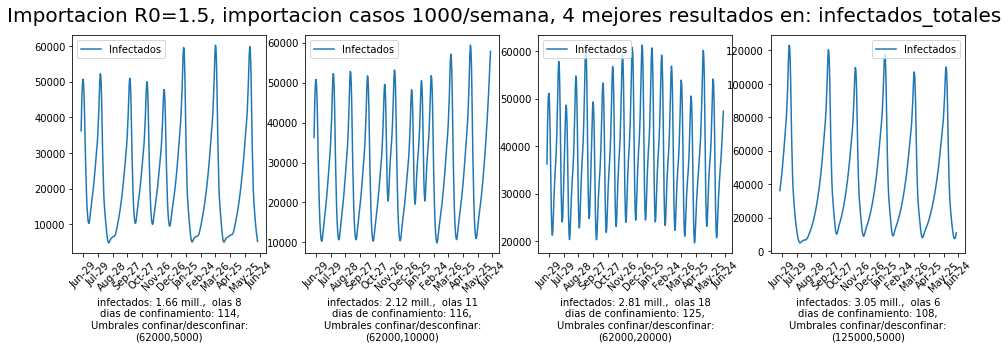

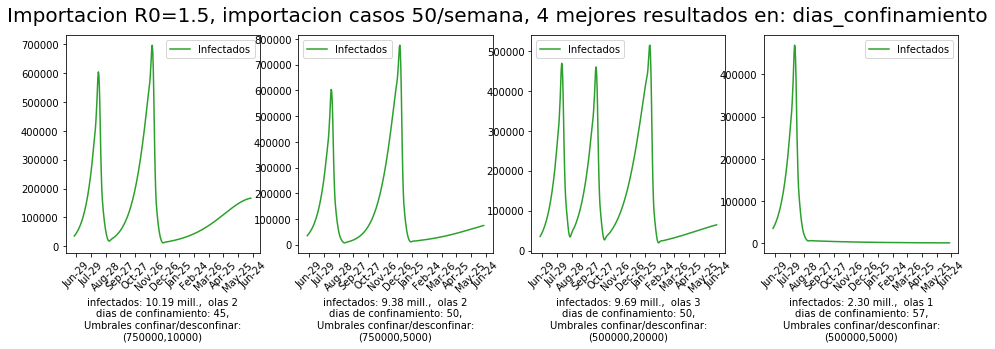

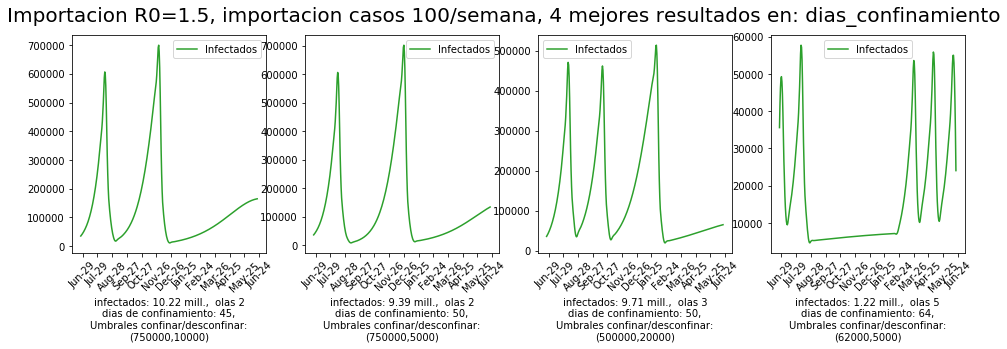

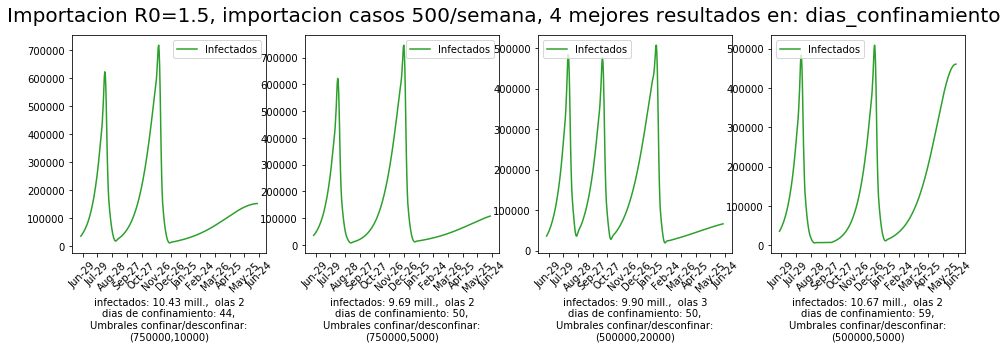

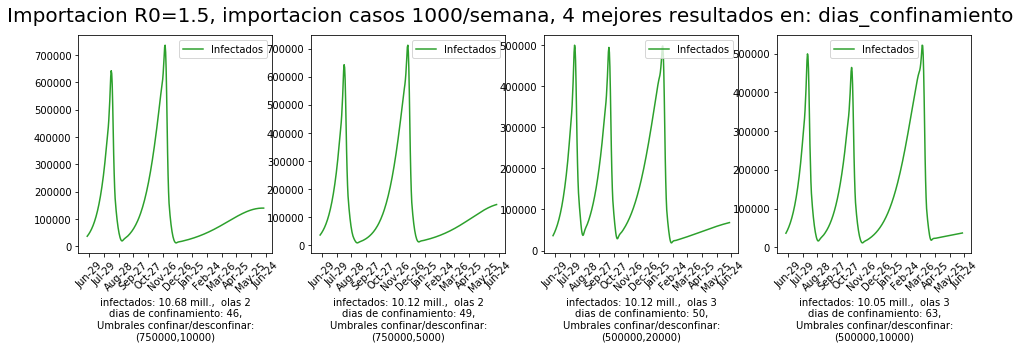

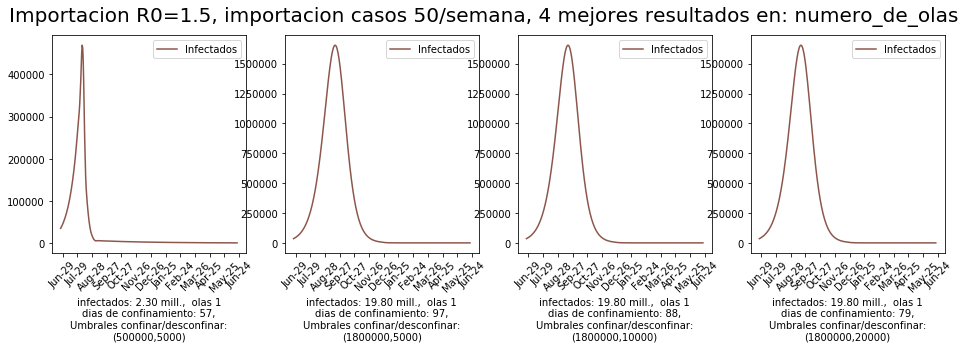

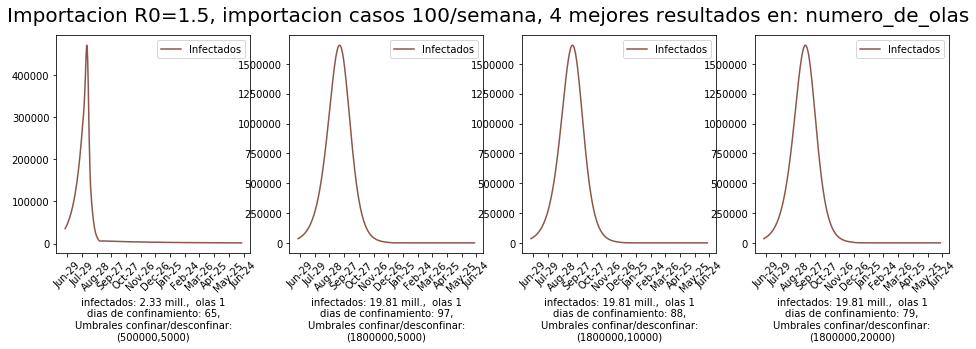

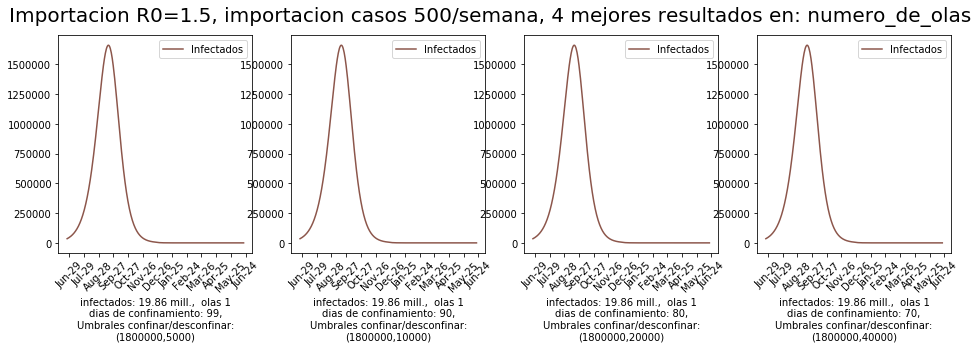

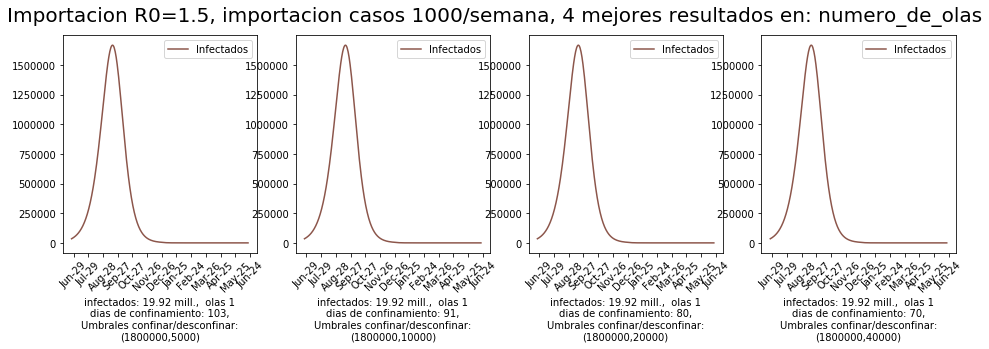

In [15]:
# Caso Datos Importados
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=26400

array_parametros_estudio_importacion = [ 
 { "escenario" : "Importacion" ,   "descripcion" : "Importacion R0=1.5, importacion casos 50/semana" ,
    "imported_cases_unlockdown_weekly" : 50 ,  "imported_cases_lockdown_weekly"    :  20    } ,
 { "escenario" : "Importacion" ,   "descripcion" : "Importacion R0=1.5, importacion casos 100/semana" ,
  "imported_cases_unlockdown_weekly" : 100 ,   "imported_cases_lockdown_weekly" : 40 ,   }, 
 { "escenario" : "Importacion" ,   "descripcion" : "Importacion R0=1.5, importacion casos 500/semana" ,
    "imported_cases_unlockdown_weekly" : 500 ,  "imported_cases_lockdown_weekly"    :  200  }, 
 { "escenario" : "Importacion" ,   "descripcion" : "Importacion R0=1.5, importacion casos 1000/semana" ,
   "imported_cases_unlockdown_weekly" : 1000 ,   "imported_cases_lockdown_weekly" : 400}
]
      


dict_default_values = {
    "R0_min" : 0.5,
    "INITIAL_DATE" : '2020-06-20'  ,
    "FINAL_DATE"   : '2021-06-20'  ,
    'GENERACIONES_SUBIDA' : 7 ,
    'GENERACIONES_BAJADA' : 7,
    'INITIAL_INFECTED_PEOPLE' : 4500000  ,    
    "outbreaks_detection_thresold"           :  7200                         , 
    "outbreaks_detection_efectivity_porcentage"      :  .25                          , 
    "RO_calor"          : 1.23  , 
    "INITIAL_RECOVERED_PEOPLE" : ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION,  
    "R0"  : 1.4952 ,
    }

        
importacion = Generar_Datos_Conjunto_Escenarios(array_parametros_estudio_importacion,dict_default_values,"Importacion")
Mostrar_Resultados_Conjunto_Escenarios(importacion)



## Conclusiones hipótesis casos importados.

<strong>No parece haber un gran impacto al subir los casos importados</strong>, a rasgos generales. Pero <strong>si puede influir en el nº de dias confinados</strong> - lo que a su vez si tiene impacto significativo en la economía.

Podía darse el caso de tener que elegir entre cerrar el pais para no importar casos, o cerrar el país por confinamiento, y en ambos casos sufre el sector turístico.

La conclusión mas obvia es que <strong>es necesario reforzar los mecanismos de detección</strong> en las fronteras, especialmente <strong>aeropuertos</strong>.


## Datos agregados

### Cogemos los datos anteriores, y los comparamos, para sacar conclusiones



In [16]:
# Nos quedamos solo con los mejores resultados 
import janitor
df = pd.concat([pd.DataFrame(mascarillas),pd.DataFrame(madrid),pd.DataFrame(airborne)])
df = df.drop('df', axis=1)
array_results = []
median_array = []
df_escenario=pd.DataFrame()
for escenario in df.descripcion.unique():
    df_escenario = df.filter_on(f"""descripcion == '{escenario}'"""  )
    criterio = ['infected_people', 'max_lockdown_thresold']
    criterio_order = [True, True]
    df_escenario.sort_values(by = criterio,ascending=criterio_order ,inplace=True)
    df_escenario=df_escenario.head(3)
    iter_dict=df_escenario[['lockdown_days','waves','infected_people','R0','max_lockdown_thresold','min_unlockdown_thresold']].median()
    iter_dict['escenario'] = escenario
    median_array.append(iter_dict)
    
    array_results.append(df_escenario)
    
df =pd.concat(array_results)
median_df = pd.DataFrame(median_array)

median_df = median_df.set_index('escenario')
median_df.sort_values(['R0'], inplace=True,ascending=[False])

#median_df


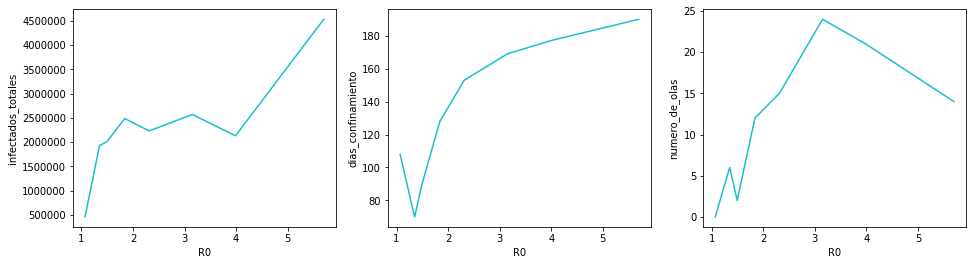

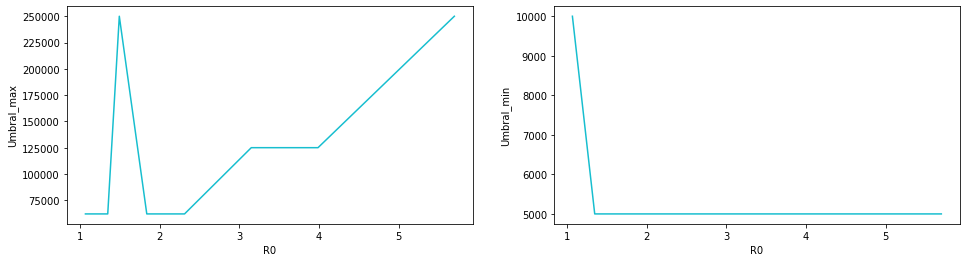

In [23]:
import seaborn as sns
display(HTML("<h2>Miramos como varia los parámetros con el R0</h2>"))

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
color='tab:cyan'
sns.lineplot(ax=ax.flatten()[0] , x="R0" ,  y="infected_people", data=median_df,color=color )
sns.lineplot(ax=ax.flatten()[1] , x="R0" ,  y="lockdown_days", data=median_df,color=color )
sns.lineplot(ax=ax.flatten()[2] , x="R0" ,  y="waves", data=median_df ,color=color)

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(ax=ax.flatten()[0] , x="R0" ,  y="max_lockdown_thresold", data=median_df ,color=color)
sns.lineplot(ax=ax.flatten()[1] , x="R0" ,  y="min_unlockdown_thresold", data=median_df ,color=color)


In [18]:
display(HTML("<h2>Cuadro resumen</h2>"))

median_df[[   'R0',
    'lockdown_days',
    'waves',
    'infected_people','max_lockdown_thresold','min_unlockdown_thresold']].style.format ({  c : "{:20,.0f}" for c in [
    'lockdown_days',
    'waves',
    'infected_people','max_lockdown_thresold','min_unlockdown_thresold'] }).format ({ 'R0':  "{:20,.3f}"}).background_gradient(cmap='Blues')




## Conclusiones

- Aquí si se ve como <strong>una buena política de confinamiento sería atajar los brotes cuanto antes</strong> - bajos umbrales de confinamiento y desconfinamiento-, aunque el umbral máximo va subiendo, conforme se incrementa R0.


- <strong>Son preferible muchas olas pequeñas, seguidas de confinamientos cortos</strong>, y espaciados igualmente en el tiempo.


- Con una buena política de umbrales confinamiento, parte sustancial del <strong> "daño" se puede absorber en la dimensión de días de confinamiento</strong>, mas que en la de número de infectados. 


- En casi todos los escenarios, menos en los mas catastróficos, los <strong> empeoramientos en el R0</strong> redundan en <strong>más días confinados</strong>, pero <strong>no en más fallecimientos</strong>.


- Es de esperar que <strong>en algunas comunidades se podrían evitar nuevas olas</strong>, pero <strong>en otras</strong> comunidades será <strong>mucho más difícil</strong>.


- Una opción sería establecer un <strong>"confinamiento mensual periódico"</strong>, p.e.: <strong>la última semana completa del mes y el fin de semana anterior</strong>, y que <strong>cada autonomía escogiera si ese mes se confina</strong> durante este periodo o no. 
Al hacer previsible los confinamientos, las empresas podrían planificar y anticiparse - los restaurantes no comprar género, las fábricas y hoteles no contratar turnos - durante esos días. 


- Este confinamiento mensual periódico <strong>mitigaría el impacto económico</strong> .


